## imports

In [44]:
import numpy as np
import pandas as pd
from string import digits
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.stats import entropy, pearsonr, ttest_1samp
from scipy.spatial.distance import cdist
from collections import OrderedDict
from decimal import Decimal
from nltk.corpus import stopwords
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import hypertools as hyp
import os
import re
import pickle

%matplotlib inline
sns.set_context('talk')

## set paths

In [45]:
vid_transc_dir = '../video transcript analysis'
answers_dir = '../graded_answers/'
figdir = '../../figures/'

## load lesson and question data

In [46]:
# Four forces
forces_video_df = pd.read_csv(os.path.join(vid_transc_dir,'fourforcesdiced.tsv'), 
                            error_bad_lines=False, header=None, sep='\t', usecols=[0])

# already formatted as sliding windows
forces_video_samples = forces_video_df[0].tolist()

In [47]:
# birth of stars
bos_video_df = pd.read_csv(os.path.join(vid_transc_dir, 'birthofstarsdiced.tsv'), 
                            error_bad_lines=False, header=None, sep='\t', usecols=[0])

# already formatted as sliding windows
bos_video_samples = pd.Series(bos_video_df[0]).tolist()

In [48]:
# questions
questions_df = pd.read_csv('../data analysis/astronomyquestions.tsv', sep='\t', 
            names=['index', 'video', 'question', 'ans_A', 'ans_B', 'ans_C', 'ans_D'], index_col='index') 

forces_questions_samples = questions_df.loc[questions_df.video == 1].question.tolist()
bos_questions_samples = questions_df.loc[questions_df.video == 2].question.tolist()
general_question_samples = questions_df.loc[questions_df.video == 0].question.tolist()

In [49]:
# link question text to qID
question_dict = {qid : questions_df.loc[qid].question for qid in questions_df.index}

## load and format participant answer data

In [50]:
data_df = pd.read_csv(os.path.join(answers_dir, 'Graded_results_19s.csv'), index_col='Unnamed: 0')

In [51]:
# dictionary format - {participantID : dataframe}
sub_data = dict()

for sub in data_df.participantID.unique():
    sub_data[sub] = data_df.loc[data_df.participantID == sub].drop('participantID', axis=1).reset_index(drop=True)

sub_data[1].head()

correct?  qID  set  video
0         1   13    0      1
1         0   21    0      2
2         0   12    0      1
3         1   16    0      2
4         1   28    0      2

## define some functions

In [52]:
vec_params = {
    'max_df': 0.95,
    'min_df': 2,
    'max_features': 500,
    'stop_words': 'english'
}

lda_params = {
    'n_components': 20,
    'max_iter': 10,
    'learning_method': 'online',
    'learning_offset':50.,
    'random_state': 0
}

In [53]:
def model_lessons_questions(v_windows, q_windows, vec_params, lda_params):
    """
    Fit a topic model to video and question content, use it to transform videos and questions.
    Returns a tuple: (video topic proportions, question topic proportions, fit topic model)
    """
    
    # initialize count vectorizer
    tf_vectorizer = CountVectorizer(**vec_params)
    # fit the model
    tf_vectorizer.fit(v_windows+q_windows)

    # transform video windows
    video_tf = tf_vectorizer.transform(v_windows)

    # transform question samples
    questions_tf = tf_vectorizer.transform(q_windows)

    both_tf = tf_vectorizer.transform(v_windows+q_windows)

    # initialize topic model
    lda = LatentDirichletAllocation(**lda_params)

    # fit topic model to video and questions
    lda.fit(both_tf)

    # transform video
    video_topics = lda.transform(video_tf)

    # smooth video model
    video_topics = pd.DataFrame(video_topics).rolling(25).mean().loc[25:,:].values

    # transform questions
    questions_topics = lda.transform(questions_tf)
    
    return video_topics, questions_topics, lda


In [54]:
def reconstruct_trace(video_model, questions_model, acc):
    """
    Function that reconstructs memory trajectory based on video model and a set of correctly answered questions
    """
    
    def normalize(x):
        xs = x - np.min(x)
        return np.divide(xs, np.max(xs))
    
    def z2r(z):
        return (np.exp(2 * z) - 1) / (np.exp(2 * z) + 1)
    
    def r2z(r):
        return 0.5 * (np.log(1 + r) - np.log(1 - r))
    
    def symmetric_KL(a, b, c=.00000000001):
        return np.divide(entropy(a+c,b+c)+entropy(b+c,a+c), 2)

    # compute timepoints by questions correlation matrix
    wz = 1-cdist(video_model, questions_model, symmetric_KL)
    
    # add the minimum value
    wz-=np.min(wz)
    
    # divide by the max value
    wz/=np.max(wz)
    
    # sum over columns
    a = np.sum(wz, axis=1)
 
    # sum over columns for correct answers
    b = np.sum(wz[:, list(map(bool, acc))], axis=1)
    
    # divide b by a
    ba = np.array(np.divide(b,a), ndmin=2)
    
    # weight the model
    return video_model*ba.T

In [55]:
def pcorrect_msd(video_topics, subject, n_questions, n_perms, p_correct = [0, .05, .25, .50, .75, .95, 1]):
    """
    Function that computes the MSD between video and question models as a function of p(correct answer)
    """
    
    dist = []
    for pc in p_correct:
        dists = []
        for perm in range(n_perms):
            acc = np.random.binomial(1, pc, n_questions).astype(int)
            recon = forces_traces_by_sub[subject]
            dists.append(np.mean(video_topics-recon)**2)
        dist.append(dists)
    return dist

In [56]:
all_stopwords = stopwords.words('english') + ["let's", "they'd", "they're", "they've", "they'll", "that's", 
                                              "I'll", "I'm"]

In [57]:
def format_text(text):
    """
    Function to format documents for tokenization and modeling
    """
    
    clean_text = []
    
    for sentence in text:
        no_punc = re.sub("[^a-zA-Z\s']+", '', sentence.lower())
        no_stop = ' '.join([word for word in no_punc.split() if word not in all_stopwords])
        clean = re.sub("'+", '', no_stop)
        clean_text.append(clean)
    
    return clean_text

In [58]:
def _r2z(r):
    """
    Function that calculates the Fisher z-transformation

    Parameters
    ----------
    r : int or ndarray
        Correlation value

    Returns
    ----------
    result : int or ndarray
        Fishers z transformed correlation value

    """
    with np.errstate(invalid='ignore', divide='ignore'):
        return 0.5 * (np.log(1 + r) - np.log(1 - r))

In [59]:
def _z2r(z):
    """
    Function that calculates the inverse Fisher z-transformation

    Parameters
    ----------
    z : int or ndarray
        Fishers z transformed correlation value

    Returns
    ----------
    result : int or ndarray
        Correlation value

    """
    with np.errstate(invalid='ignore', divide='ignore'):
        return (np.exp(2 * z) - 1) / (np.exp(2 * z) + 1)

In [60]:
def corr_mean(rs, axis=0):
    """
    Function that calculates the mean of correlation coefficients,
    performing Fisher z-transformation and inverse z-transormation
    
    Parameters
    ----------
    rs: : list or ndarray
        Correlation values
    
    Returns
    ----------
    result : float
        mean of correlation values

    """
    return _z2r(np.nanmean([_r2z(r) for r in rs], axis=axis))

# _Four Forces_

### model lecture video and questions

In [18]:
# forces_v_traj, forces_q_traj, forces_tm = model_lessons_questions(forces_video_samples, forces_questions_samples, 
#                                                            vec_params, lda_params)

In [19]:
# sns.heatmap(forces_v_traj, vmin=0, vmax=1)
# plt.title('Four Forces lecture topic proportions')
# plt.xlabel('Topic')
# plt.ylabel('Time')
# # plt.savefig(figdir+'forces-lecture-toppropsmat.pdf', bbox_inches='tight')
# plt.show()

# sns.heatmap(forces_q_traj, vmin=0, vmax=1, linewidths=0.01, linecolor='gray')
# plt.title('Four Forces questions topic proportions')
# plt.xlabel('Topic')
# plt.ylabel('Question')
# # plt.savefig(figdir+'forces-questions-toppropsmat.pdf', bbox_inches='tight')
# plt.show()

In [20]:
# sns.heatmap(pd.DataFrame(forces_v_traj).T.corr(), vmin=0, vmax=1)
# plt.title('Four Forces lecture temporal correlation matrix')
# plt.xlabel('Time')
# plt.ylabel('Time')
# # plt.savefig(figdir+'forces-lecture-corrmat.pdf', bbox_inches='tight')
# plt.show()

In [21]:
# sns.set_context('notebook')
# hyp.plot([forces_v_traj, forces_q_traj], ['k-', 'ro'], reduce='IncrementalPCA', 
#          legend=['Lecture content', 'Question content'])
# plt.show()

### What moments of lecture content does each question cover?

In [22]:
# sns.set_palette('hls')
# sns.set_context('talk')

In [23]:
# plt.figure(figsize=(8,5))
# plt.plot(1-cdist(forces_v_traj, forces_q_traj, 'correlation'))
# plt.xlabel('Video timepoint')
# plt.ylabel('Video-question\ntopic correlation')
# plt.title('Four Forces: lecture-question content similarity')
# plt.legend(labels=[f'Q {i+1}' for i in range(forces_q_traj.shape[0])], fontsize='x-small', bbox_to_anchor=(1,1.05))
# plt.grid(False)
# # plt.savefig(figdir+'forces-v-q-similarity.pdf', bbox_inches='tight')
# plt.show()

### reconstruct eaech subject's learning trace for each set of questions viewed

In [24]:
# forces_traces_set0 = {}
# forces_traces_set1 = {}
# forces_traces_set2 = {}

# for sid, df in sub_data.items():
#     # get questions about Four Forces viewed in first block 
#     set0_fqs = df.loc[df.set == 0].loc[df.video == 1]
#     # extract their topic vectors by index
#     set0_fqs_vecs = forces_q_traj[[forces_questions_samples.index(question_dict[i]) for i in set0_fqs.qID]]
#     # get accuracy for those questions
#     set0_fqs_acc = set0_fqs['correct?']
    
#     forces_traces_set0[sid] = reconstruct_trace(forces_v_traj, set0_fqs_vecs, set0_fqs_acc)
    
# for sid, df in sub_data.items():
#     # get questions about Four Forces viewed in second block 
#     set1_fqs = df.loc[df.set == 1].loc[df.video == 1]
#     # extract their topic vectors by index
#     set1_fqs_vecs = forces_q_traj[[forces_questions_samples.index(question_dict[i]) for i in set1_fqs.qID]]
#     # get accuracy for those questions
#     set1_fqs_acc = set1_fqs['correct?']
    
#     forces_traces_set1[sid] = reconstruct_trace(forces_v_traj, set1_fqs_vecs, set1_fqs_acc)
    
# for sid, df in sub_data.items():
#     # get questions about Four Forces viewed in third block 
#     set2_fqs = df.loc[df.set == 2].loc[df.video == 1]
#     # extract their topic vectors by index
#     set2_fqs_vecs = forces_q_traj[[forces_questions_samples.index(question_dict[i]) for i in set2_fqs.qID]]
#     # get accuracy for those questions
#     set2_fqs_acc = set2_fqs['correct?']
    
#     forces_traces_set2[sid] = reconstruct_trace(forces_v_traj, set2_fqs_vecs, set2_fqs_acc)

In [25]:
# avg_force_trace0 = np.mean(list(forces_traces_set0.values()), axis=0)
# avg_force_trace1 = np.mean(list(forces_traces_set1.values()), axis=0)
# avg_force_trace2 = np.mean(list(forces_traces_set2.values()), axis=0)

In [26]:
# sns.set_context('notebook')

In [27]:
# hyp.plot([forces_v_traj, forces_q_traj, avg_force_trace0, avg_force_trace1, avg_force_trace2], 
#          fmt=['k-', 'ro', 'b--', 'y--', 'g--'], reduce='IncrementalPCA', size=[9, 6],
#          title='Four Forces: Lecture, questions, and learning',
#          legend=['Lecture content', 'Question content', 
#                  'Learned content: Qset 0', 
#                  'Learned content: Qset 1', 
#                  'Learned content: Qset 2'])#, save_path='/Users/paxtonfitzpatrick/Desktop/forces-reconstructed.pdf')

# # ax1.legend(labels = ['Lecture content', 'Question content', 
# #                  'Learning trajectory: Qset 0', 
# #                  'Learning trajectory: Qset 1', 
# #                  'Learning trajectory: Qset 2'])

### How does the difference between viewed and learned content change after viewing the lecture?

In [28]:
# # pairwise euclidean distance (slightly less exact than np.diag of scipy.spatial.distance.cdist)
# def distance(x, y):
#     return np.sqrt(np.dot(x, x) - 2 * np.dot(x, y) + np.dot(y, y))

In [29]:
# distances = np.array([np.diag(cdist(forces_v_traj, aft, metric='euclidean')) 
#                       for aft in [avg_force_trace0, avg_force_trace1, avg_force_trace2]]).T

# perfect = np.array([0 for i in range(forces_v_traj.shape[0])], ndmin=2).T

In [30]:
# sns.set_palette('hls')
# sns.set_style('ticks')
# sns.set_context('talk')

In [31]:
# plt.plot(np.hstack([perfect, distances]))
# plt.ylim(-.025, .825)
# plt.xlim(0, forces_v_traj.shape[0])
# plt.xlabel('Lecture timepionts')
# plt.ylabel('Lecture content-learned content\nEuclidean distance')
# plt.title('Four Forces: Moment-by-moment content mastery')
# plt.legend(labels=['Lecture content','Learned content: Qset 0','Learned content: Qset 1',
#                    'Learned content: Qset 2'], fontsize='small', bbox_to_anchor=(1,.7))
# # plt.savefig(figdir+'forces-lecture-trace-eucdist.pdf', bbox_inches='tight')
# plt.show()

In [32]:
# plt.bar(x=list(range(3)), height=(distances**2).mean(axis=0), tick_label=['Qset 0', 'Qset 1', 'Qset 2'],
#        color=[(0.8288, 0.86, 0.34),(0.34, 0.86, 0.3712),(0.34, 0.8288, 0.86)])
# plt.ylim(0,0.26)
# plt.xlabel('Question set')
# plt.ylabel('Mean squared distance')
# plt.title('Four Forces: Lecture vs knowledge differences')
# plt.vlines(x=.5, ymin=0, ymax=0.3, linestyles='dashed', colors='gray')
# # plt.savefig(figdir+'forces-msd-by-qset.pdf', bbox_inches='tight')
# plt.show()

# _Birth of Stars_

### model lecture video and questions

In [33]:
# bos_v_traj, bos_q_traj, bos_tm = model_lessons_questions(bos_video_samples, bos_questions_samples, 
#                                                            vec_params, lda_params)

In [34]:
# sns.heatmap(bos_v_traj, vmin=0, vmax=1)
# plt.title('Birth of Stars lecture topic proportions')
# plt.xlabel('Topic')
# plt.ylabel('Time')
# # plt.savefig(figdir+'bos-lecture-toppropsmat.pdf', bbox_inches='tight')
# plt.show()

# sns.heatmap(bos_q_traj, vmin=0, vmax=1, linewidths=0.01, linecolor='gray')
# plt.title('Birth of Stars questions topic proportions')
# plt.xlabel('Topic')
# plt.ylabel('Question')
# # plt.savefig(figdir+'bos-questions-toppropsmat.pdf', bbox_inches='tight')
# plt.show()

In [35]:
# sns.heatmap(pd.DataFrame(bos_v_traj).T.corr(), vmin=0, vmax=1)
# plt.title('Birth of Stars lecture temporal correlation matrix')
# plt.xlabel('Time')
# plt.ylabel('Time')
# # plt.savefig(figdir+'bos-lecture-corrmat.pdf', bbox_inches='tight')
# plt.show()

In [36]:
# sns.set_context('notebook')
# hyp.plot([bos_v_traj, bos_q_traj], ['k-', 'ro'], reduce='IncrementalPCA', 
#          legend=['Lecture content', 'Question content'])
# plt.show()

### What moments of lecture content does each question cover?

In [37]:
# sns.set_palette('hls')
# sns.set_context('talk')

In [38]:
# plt.figure(figsize=(8,5))
# plt.plot(1-cdist(bos_v_traj, bos_q_traj, 'correlation'))
# plt.xlabel('Video timepoint')
# plt.ylabel('Video-question\ntopic correlation')
# plt.title('Birth of Stars: lecture-question content similarity')
# plt.legend(labels=[f'Q {i+1}' for i in range(bos_q_traj.shape[0])], fontsize='x-small', bbox_to_anchor=(1,1.05))
# plt.grid(False)
# # plt.savefig(figdir+'bos-v-q-similarity.pdf', bbox_inches='tight')
# plt.show()

### reconstruct eaech subject's learning trace for each set of questions viewed

In [39]:
# bos_traces_set0 = {}
# bos_traces_set1 = {}
# bos_traces_set2 = {}

# for sid, df in sub_data.items():
#     # get questions about Birth of Stars viewed in first block 
#     set0_fqs = df.loc[df.set == 0].loc[df.video == 2]
#     # extract their topic vectors by index
#     set0_fqs_vecs = bos_q_traj[[bos_questions_samples.index(question_dict[i]) for i in set0_fqs.qID]]
#     # get accuracy for those questions
#     set0_fqs_acc = set0_fqs['correct?']
    
#     bos_traces_set0[sid] = reconstruct_trace(bos_v_traj, set0_fqs_vecs, set0_fqs_acc)
    
# for sid, df in sub_data.items():
#     # get questions about Birth of Stars viewed in first block 
#     set1_fqs = df.loc[df.set == 1].loc[df.video == 2]
#     # extract their topic vectors by index
#     set1_fqs_vecs = bos_q_traj[[bos_questions_samples.index(question_dict[i]) for i in set1_fqs.qID]]
#     # get accuracy for those questions
#     set1_fqs_acc = set1_fqs['correct?']
    
#     bos_traces_set1[sid] = reconstruct_trace(bos_v_traj, set1_fqs_vecs, set1_fqs_acc)
    
# for sid, df in sub_data.items():
#     # get questions about Birth of Stars viewed in first block 
#     set2_fqs = df.loc[df.set == 2].loc[df.video == 2]
#     # extract their topic vectors by index
#     set2_fqs_vecs = bos_q_traj[[bos_questions_samples.index(question_dict[i]) for i in set2_fqs.qID]]
#     # get accuracy for those questions
#     set2_fqs_acc = set2_fqs['correct?']
    
#     bos_traces_set2[sid] = reconstruct_trace(bos_v_traj, set2_fqs_vecs, set2_fqs_acc)

In [40]:
# avg_bos_trace0 = np.mean(list(bos_traces_set0.values()), axis=0)
# avg_bos_trace1 = np.mean(list(bos_traces_set1.values()), axis=0)
# avg_bos_trace2 = np.mean(list(bos_traces_set2.values()), axis=0)

In [41]:
# sns.set_context('notebook')

In [42]:
# hyp.plot([bos_v_traj, bos_q_traj, avg_bos_trace0, avg_bos_trace1, avg_bos_trace2], 
#          fmt=['k-', 'ro', 'b--', 'y--', 'g--'], reduce='IncrementalPCA', size=[9, 6],
#          title='Birth of Stars: Lecture, questions, and learning',
#          legend=['Lecture content', 'Question content', 
#                  'Learned content: Qset 0', 
#                  'Learned content: Qset 1', 
#                  'Learned content: Qset 2'])#, save_path=figdir+'bos-reconstructed.pdf')

# # ax1.legend(labels = ['Lecture content', 'Question content', 
# #                  'Learning trajectory: Qset 0', 
# #                  'Learning trajectory: Qset 1', 
# #                  'Learning trajectory: Qset 2'])

### How does the difference between viewed and learned content change after viewing the lecture?

In [43]:
# bos_distances = np.array([np.diag(cdist(bos_v_traj, abt, metric='euclidean')) 
#                       for abt in [avg_bos_trace0, avg_bos_trace1, avg_bos_trace2]]).T

# bos_perfect = np.array([0 for i in range(bos_v_traj.shape[0])], ndmin=2).T

In [44]:
# sns.set_palette('hls')
# sns.set_style('ticks')
# sns.set_context('talk')

In [45]:
# plt.plot(np.hstack([bos_perfect, bos_distances]))
# plt.ylim(-.025, .625)
# plt.xlim(0, bos_v_traj.shape[0])
# plt.xlabel('Lecture timepionts')
# plt.ylabel('Lecture content-learned content\nEuclidean distance')
# plt.title('Birth of Stars: Moment-by-moment content mastery')
# plt.legend(labels=['Lecture content','Learned content: Qset 0','Learned content: Qset 1',
#                    'Learned content: Qset 2'], fontsize='small', bbox_to_anchor=(1,.7))
# # plt.savefig(figdir+'bos-lecture-trace-eucdist.pdf', bbox_inches='tight')
# plt.show()

In [46]:
# plt.bar(x=list(range(3)), height=(bos_distances**2).mean(axis=0), tick_label=['Qset 0', 'Qset 1', 'Qset 2'],
#        color=[(0.8288, 0.86, 0.34),(0.34, 0.86, 0.3712),(0.34, 0.8288, 0.86)])
# plt.ylim(0,0.26)
# plt.xlabel('Question set')
# plt.ylabel('Mean squared distance')
# plt.title('Birth of Stars: Lecture vs knowledge differences')
# plt.vlines(x=1.5, ymin=0, ymax=0.3, linestyles='dashed', colors='gray')
# # plt.savefig(figdir+'bos-msd-by-qset.pdf', bbox_inches='tight')
# plt.show()

In [61]:
lda_params = {
    'n_components': 12,
    'max_iter': 10,
    'learning_method': 'online',
    'learning_offset':50.,
    'random_state': 0
}

In [62]:
fvs_formatted = format_text(forces_video_samples)
bvs_formatted = format_text(bos_video_samples)
fqs_formatted = format_text(forces_questions_samples)
bqs_formatted = format_text(bos_questions_samples)
gqs_formatted = format_text(general_question_samples)

### analyses with model fit to both lectures and all questions

In [63]:
# # initialize count vectorizer
# tf_vectorizer = CountVectorizer(**vec_params)

# # fit to both lectures and all questions
# tf_vectorizer.fit(fvs_formatted + fqs_formatted
#                   + bvs_formatted + bqs_formatted
#                   + gqs_formatted)

# # transform lecture windows
# forces_video_tf = tf_vectorizer.transform(fvs_formatted)
# bos_video_tf = tf_vectorizer.transform(bvs_formatted)

# # transform question samples
# forces_questions_tf = tf_vectorizer.transform(fqs_formatted)
# bos_questions_tf = tf_vectorizer.transform(bqs_formatted)
# general_questions_tf = tf_vectorizer.transform(gqs_formatted)

# all_tf = tf_vectorizer.transform(fvs_formatted + fqs_formatted
#                   + bvs_formatted + bqs_formatted
#                   + gqs_formatted)

# # initialize LDA model, fit to both lectures and all questions
# lda = LatentDirichletAllocation(**lda_params)
# lda.fit(all_tf)

# # transform lectures
# forces_v_traj = lda.transform(forces_video_tf)
# bos_v_traj = lda.transform(bos_video_tf)

# # smooth lecture models
# forces_v_traj = pd.DataFrame(forces_v_traj).rolling(25).mean().loc[25:,:].values
# bos_v_traj = pd.DataFrame(bos_v_traj).rolling(25).mean().loc[25:,:].values

# # transform questions
# forces_q_traj = lda.transform(forces_questions_tf)
# bos_q_traj = lda.transform(bos_questions_tf)
# general_q_traj = lda.transform(general_questions_tf)


# analyses with model fit to lectures and lecture-related questions

In [70]:
# initialize count vectorizer
tf_vectorizer = CountVectorizer(**vec_params)

# fit to both lectures and all questions
tf_vectorizer.fit(fvs_formatted + fqs_formatted
                  + bvs_formatted + bqs_formatted)

# transform lecture windows
forces_video_tf = tf_vectorizer.transform(fvs_formatted)
bos_video_tf = tf_vectorizer.transform(bvs_formatted)

# transform question samples
forces_questions_tf = tf_vectorizer.transform(fqs_formatted)
bos_questions_tf = tf_vectorizer.transform(bqs_formatted)
general_questions_tf = tf_vectorizer.transform(gqs_formatted)

all_tf = tf_vectorizer.transform(fvs_formatted + fqs_formatted
                  + bvs_formatted + bqs_formatted)

# initialize LDA model, fit to both lectures and all questions
lda = LatentDirichletAllocation(**lda_params)
lda.fit(all_tf)

# transform lectures
forces_v_traj = lda.transform(forces_video_tf)
bos_v_traj = lda.transform(bos_video_tf)

# smooth lecture models
forces_v_traj = pd.DataFrame(forces_v_traj).rolling(25).mean().loc[25:,:].values
bos_v_traj = pd.DataFrame(bos_v_traj).rolling(25).mean().loc[25:,:].values

# transform questions
forces_q_traj = lda.transform(forces_questions_tf)
bos_q_traj = lda.transform(bos_questions_tf)
general_q_traj = lda.transform(general_questions_tf)


### analyses with model fit to both lectures (no questions)

In [51]:
# # initialize count vectorizer
# tf_vectorizer = CountVectorizer(**vec_params)

# # fit to both lectures and all questions
# tf_vectorizer.fit(fvs_formatted + bvs_formatted)

# # transform lecture windows
# forces_video_tf = tf_vectorizer.transform(fvs_formatted)
# bos_video_tf = tf_vectorizer.transform(bvs_formatted)

# # transform question samples
# forces_questions_tf = tf_vectorizer.transform(fqs_formatted)
# bos_questions_tf = tf_vectorizer.transform(bqs_formatted)
# general_questions_tf = tf_vectorizer.transform(gqs_formatted)

# videos_tf = tf_vectorizer.transform(fvs_formatted + bvs_formatted)

# # initialize LDA model, fit to both lectures and all questions
# lda = LatentDirichletAllocation(**lda_params)
# lda.fit(videos_tf)

# # transform lectures
# forces_v_traj = lda.transform(forces_video_tf)
# bos_v_traj = lda.transform(bos_video_tf)

# # smooth lecture models
# forces_v_traj = pd.DataFrame(forces_v_traj).rolling(25).mean().loc[25:,:].values
# bos_v_traj = pd.DataFrame(bos_v_traj).rolling(25).mean().loc[25:,:].values

# # transform questions
# forces_q_traj = lda.transform(forces_questions_tf)
# bos_q_traj = lda.transform(bos_questions_tf)
# general_q_traj = lda.transform(general_questions_tf)


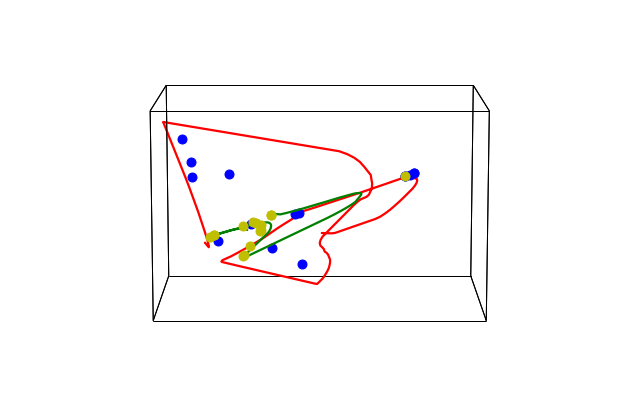

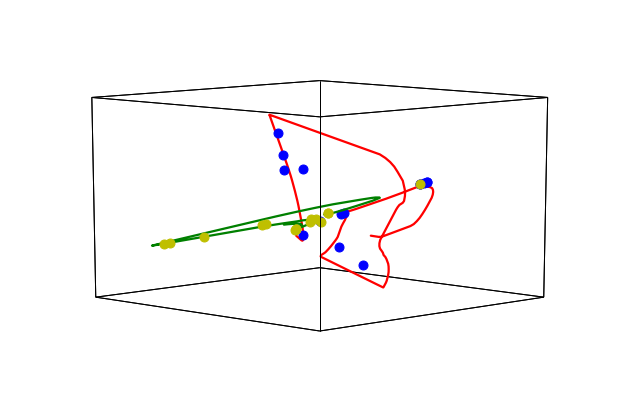

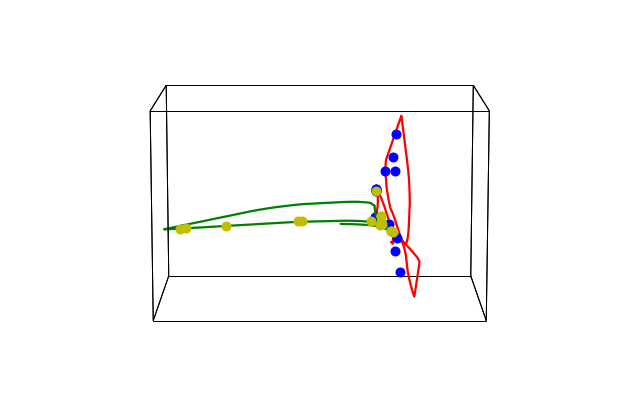

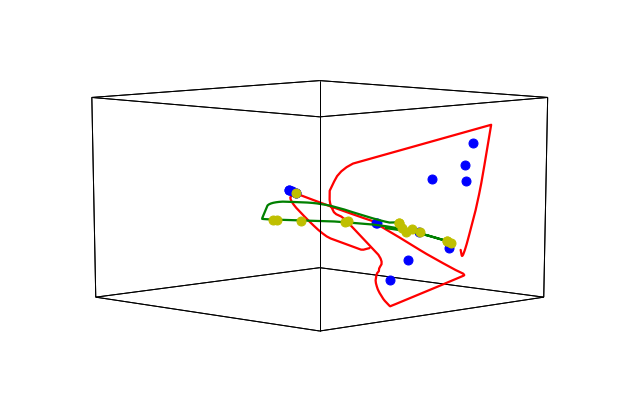

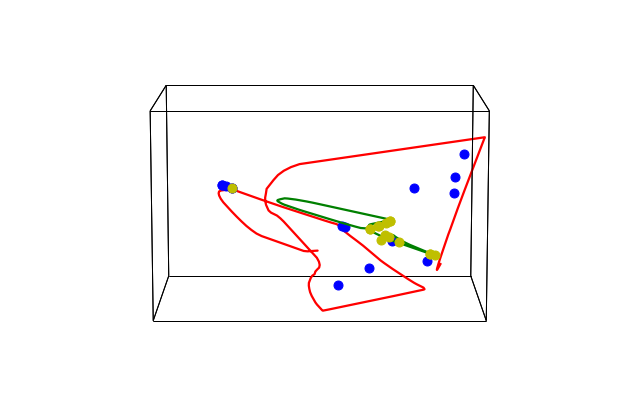

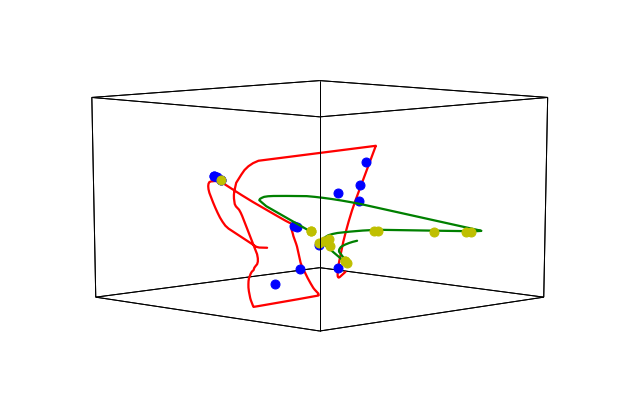

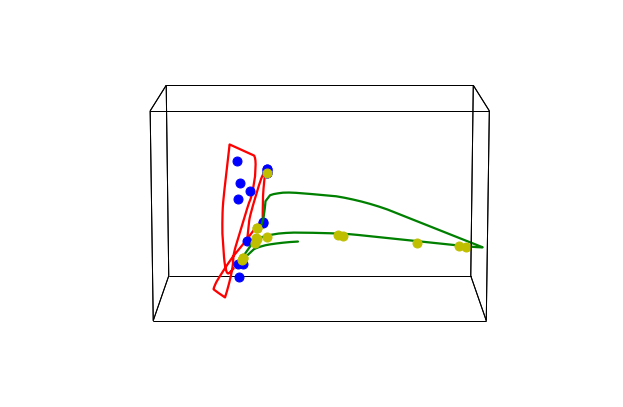

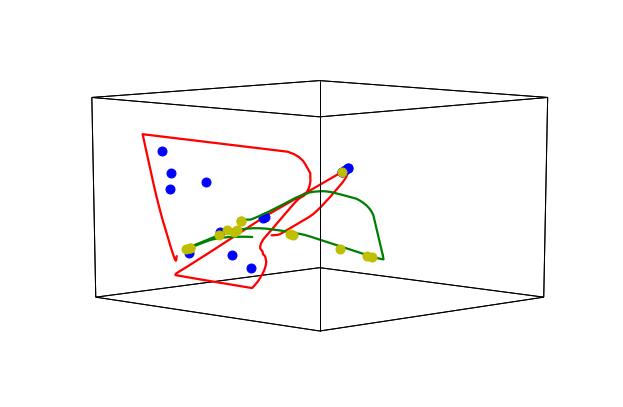

In [52]:
# spot check modeling of lectures and related questions
for azim in range(0, 360, 45):
    
    hyp.plot([forces_v_traj, forces_q_traj, bos_v_traj, bos_q_traj], fmt=['r-', 'bo', 'g-', 'yo'],
             reduce='IncrementalPCA', size=[9, 6], azim=azim)
    plt.show()

# _Four Forces_

In [53]:
sns.set_context('talk')
sns.set_style('white')

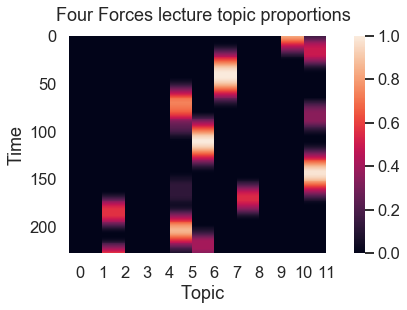

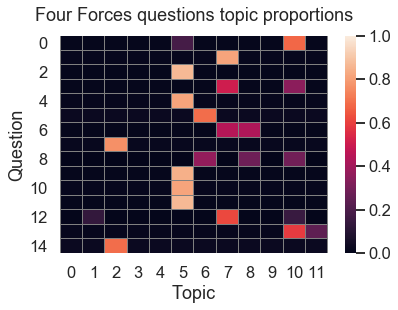

In [54]:
fig, a = plt.subplots(1,1)
fig.set_size_inches(6,4)
a = sns.heatmap(forces_v_traj, vmin=0, vmax=1, yticklabels=50)
a.set_title('Four Forces lecture topic proportions', y=1.04)
a.set_xlabel('Topic')
a.set_ylabel('Time')
plt.yticks(rotation=0)
a.collections[0].remove()
a.imshow(forces_v_traj, aspect='auto')
# plt.savefig(figdir+'fit_all/forces-lecture-toppropsmat.pdf', bbox_inches='tight')
plt.show()

fig, a = plt.subplots(1,1)
fig.set_size_inches(6,4)
a = sns.heatmap(forces_q_traj, vmin=0, vmax=1, linewidths=0.01, linecolor='gray')
a.set_title('Four Forces questions topic proportions', y=1.04)
a.set_xlabel('Topic')
a.set_ylabel('Question')
plt.yticks(rotation=0)
# plt.savefig(figdir+'fit_all/forces-questions-toppropsmat.pdf', bbox_inches='tight')
plt.show()

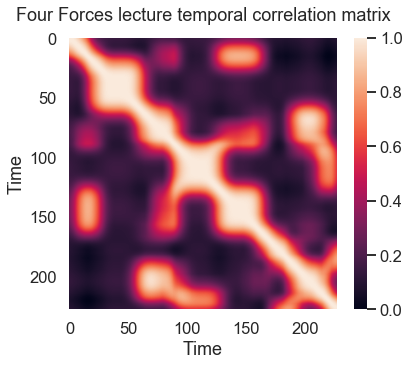

In [55]:
fig, a = plt.subplots(1,1)
fig.set_size_inches(6, 5)
a = sns.heatmap(pd.DataFrame(forces_v_traj).T.corr(), vmin=0, vmax=1, xticklabels=50, yticklabels=50)
a.set_title('Four Forces lecture temporal correlation matrix', y=1.04)
a.set_xlabel('Time')
a.set_ylabel('Time')
plt.yticks(rotation=0)
a.collections[0].remove()
a.imshow(pd.DataFrame(forces_v_traj).T.corr(), aspect='auto', interpolation='bilinear')
# plt.savefig(figdir+'fit_all/forces-lecture-corrmat.pdf', bbox_inches='tight')
plt.show()

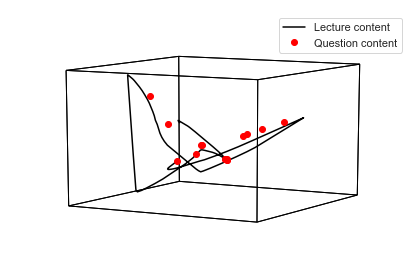

In [56]:
sns.set_context('notebook')
hyp.plot([forces_v_traj, forces_q_traj], ['k-', 'ro'], reduce='IncrementalPCA', 
         legend=['Lecture content', 'Question content'])
plt.show()

### What moments of lecture content does each question cover?

In [57]:
sns.set_palette('hls', 15)
sns.set_context('talk')

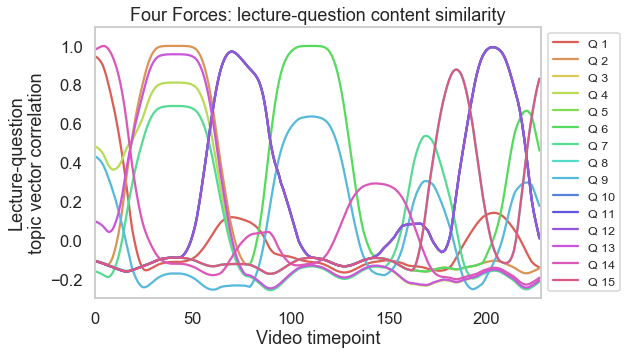

In [58]:
plt.figure(figsize=(8,5))
plt.plot(1-cdist(forces_v_traj, forces_q_traj, 'correlation'))
plt.xlim(0,forces_v_traj.shape[0])
plt.ylim(-.3,1.1)
plt.xlabel('Video timepoint')
plt.ylabel('Lecture-question\ntopic vector correlation')
plt.title('Four Forces: lecture-question content similarity')
plt.legend(labels=[f'Q {i+1}' for i in range(forces_q_traj.shape[0])], fontsize='x-small', bbox_to_anchor=(1,1))
plt.grid(False)
# plt.savefig(figdir+'fit_all/forces-v-q-similarity.pdf', bbox_inches='tight')
plt.show()

### reconstruct eaech subject's learning trace for each set of questions viewed

In [59]:
forces_traces_set0 = {}
forces_traces_set1 = {}
forces_traces_set2 = {}

for sid, df in sub_data.items():
    # get questions about Four Forces viewed in first block 
    set0_fqs = df.loc[df.set == 0].loc[df.video == 1]
    # extract their topic vectors by index
    set0_fqs_vecs = forces_q_traj[[forces_questions_samples.index(question_dict[i]) for i in set0_fqs.qID]]
    # get accuracy for those questions
    set0_fqs_acc = set0_fqs['correct?']
    
    forces_traces_set0[sid] = reconstruct_trace(forces_v_traj, set0_fqs_vecs, set0_fqs_acc)
    
for sid, df in sub_data.items():
    # get questions about Four Forces viewed in first block 
    set1_fqs = df.loc[df.set == 1].loc[df.video == 1]
    # extract their topic vectors by index
    set1_fqs_vecs = forces_q_traj[[forces_questions_samples.index(question_dict[i]) for i in set1_fqs.qID]]
    # get accuracy for those questions
    set1_fqs_acc = set1_fqs['correct?']
    
    forces_traces_set1[sid] = reconstruct_trace(forces_v_traj, set1_fqs_vecs, set1_fqs_acc)
    
for sid, df in sub_data.items():
    # get questions about Four Forces viewed in first block 
    set2_fqs = df.loc[df.set == 2].loc[df.video == 1]
    # extract their topic vectors by index
    set2_fqs_vecs = forces_q_traj[[forces_questions_samples.index(question_dict[i]) for i in set2_fqs.qID]]
    # get accuracy for those questions
    set2_fqs_acc = set2_fqs['correct?']
    
    forces_traces_set2[sid] = reconstruct_trace(forces_v_traj, set2_fqs_vecs, set2_fqs_acc)

In [60]:
avg_force_trace0 = np.mean(list(forces_traces_set0.values()), axis=0)
avg_force_trace1 = np.mean(list(forces_traces_set1.values()), axis=0)
avg_force_trace2 = np.mean(list(forces_traces_set2.values()), axis=0)

In [61]:
sns.set_context('notebook')

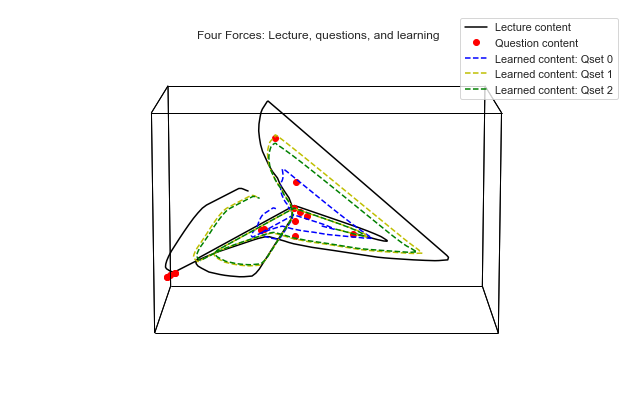

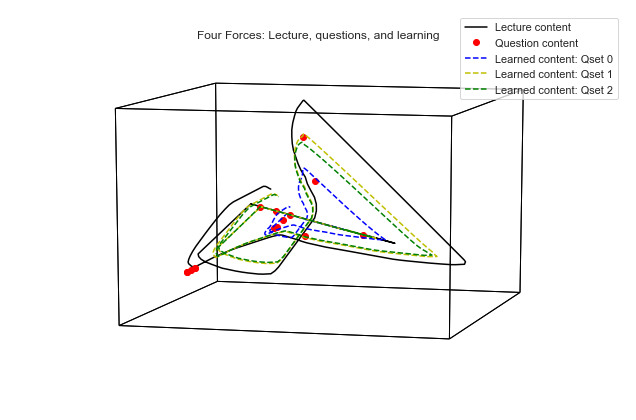

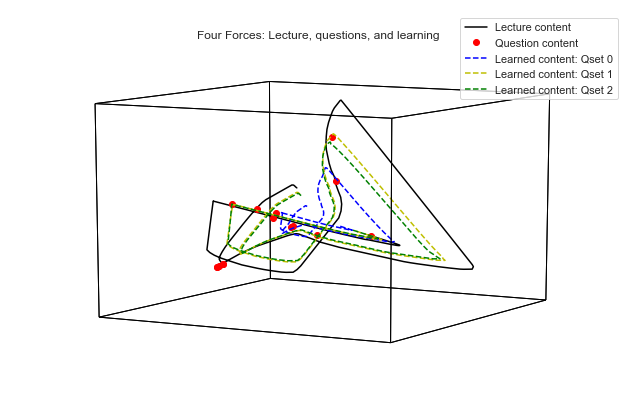

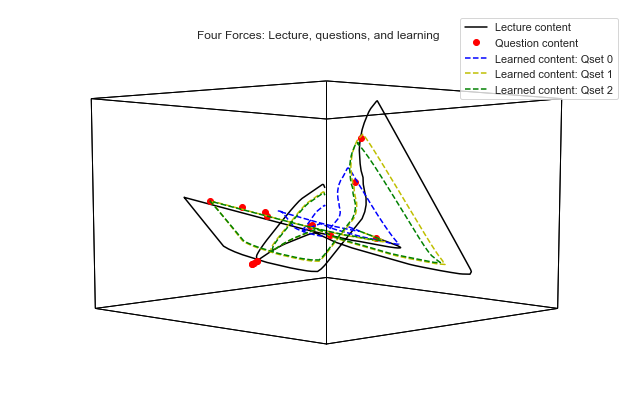

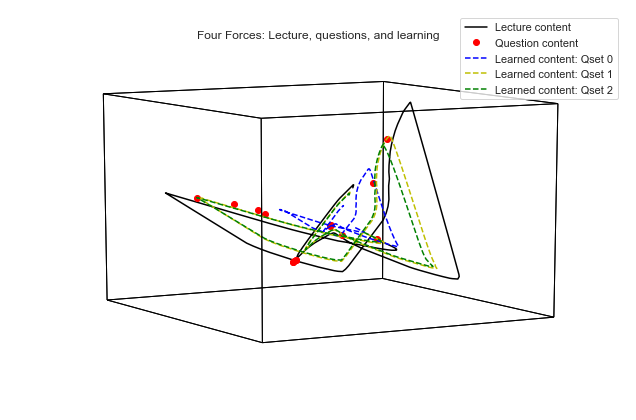

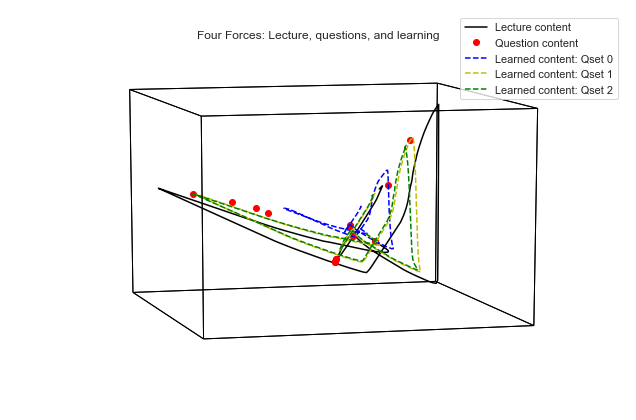

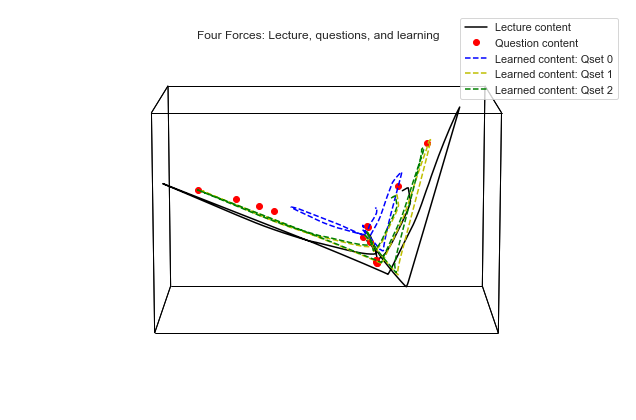

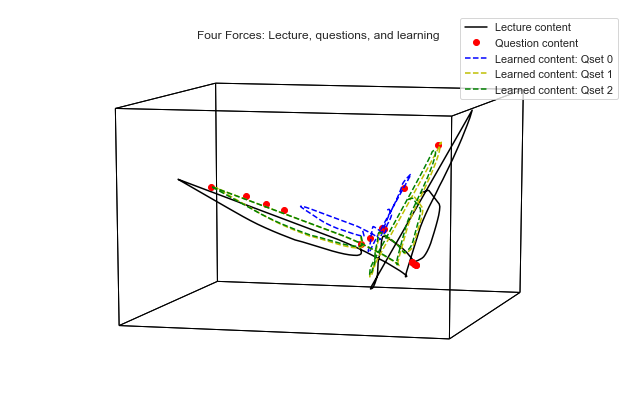

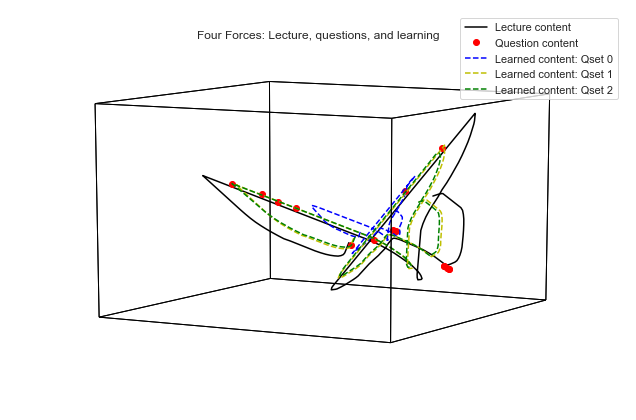

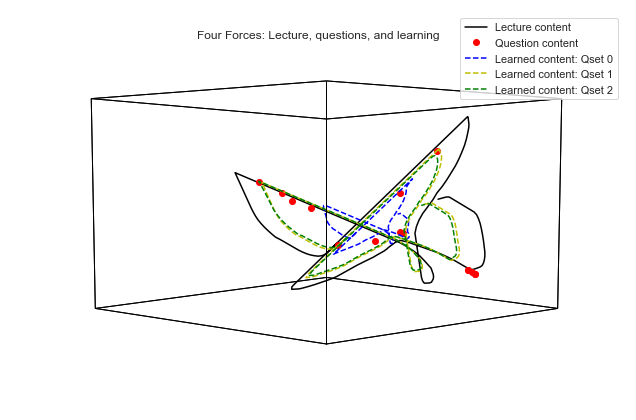

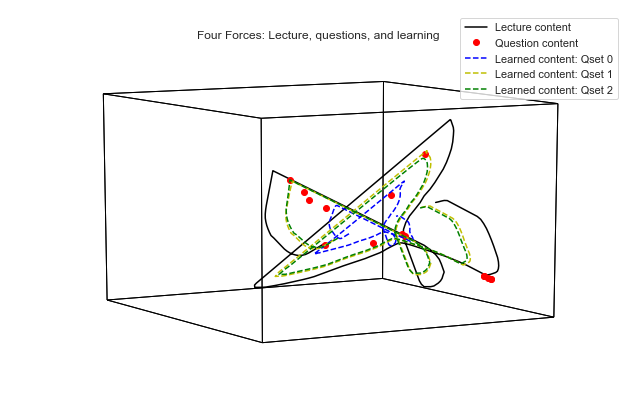

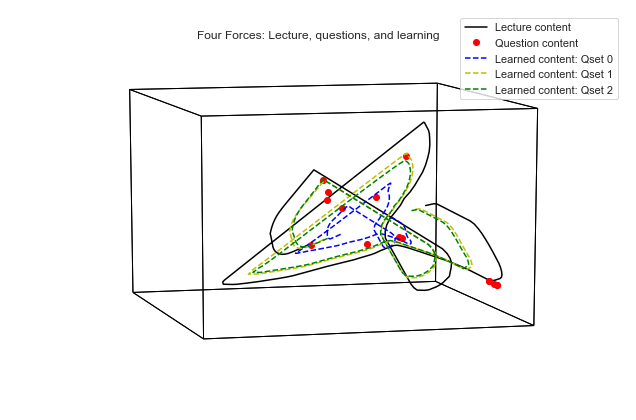

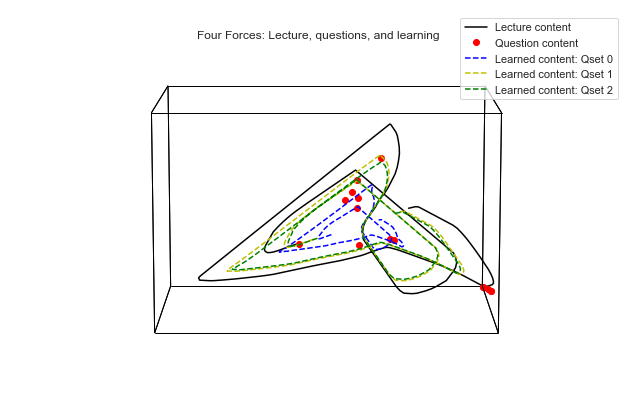

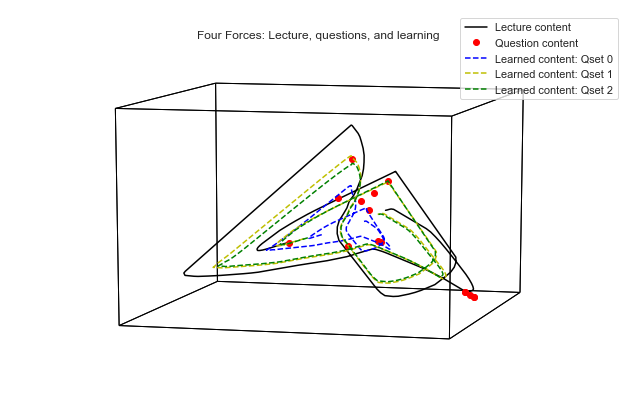

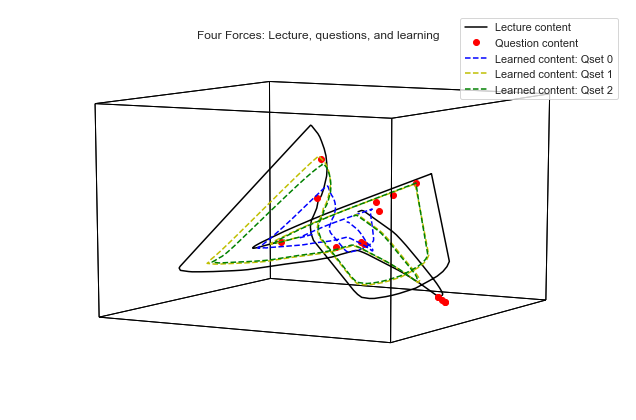

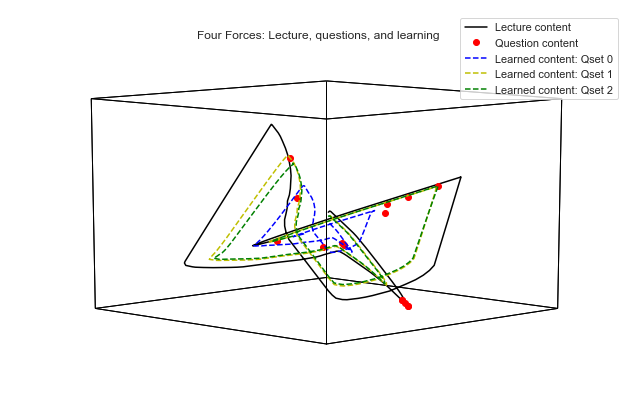

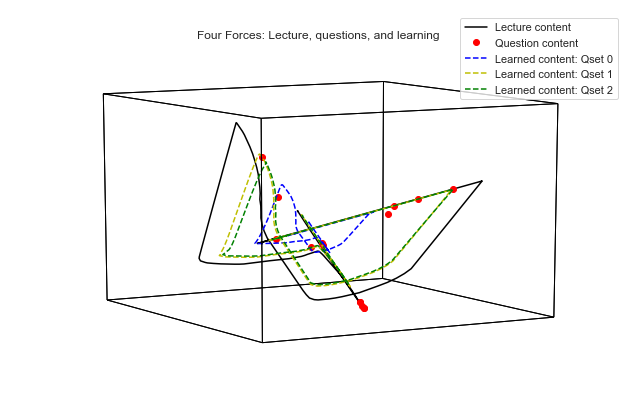

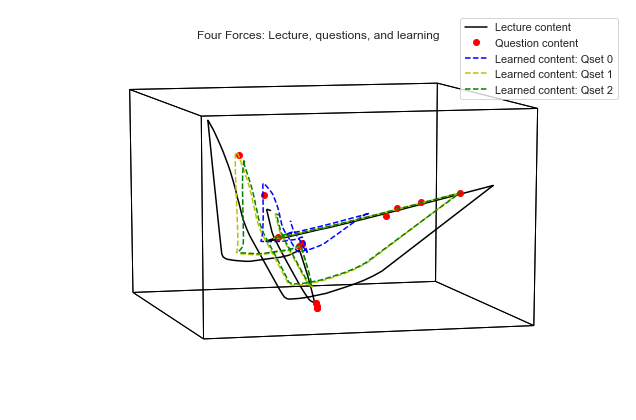

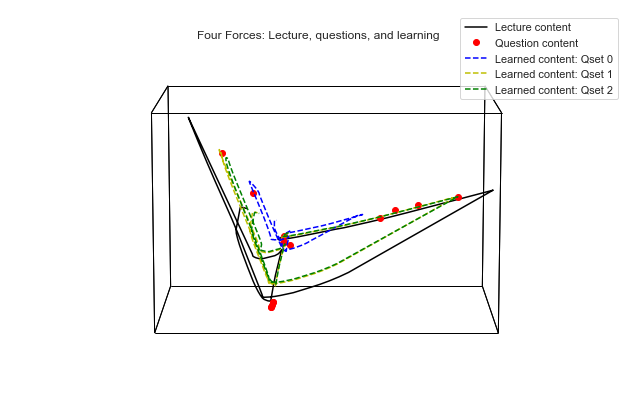

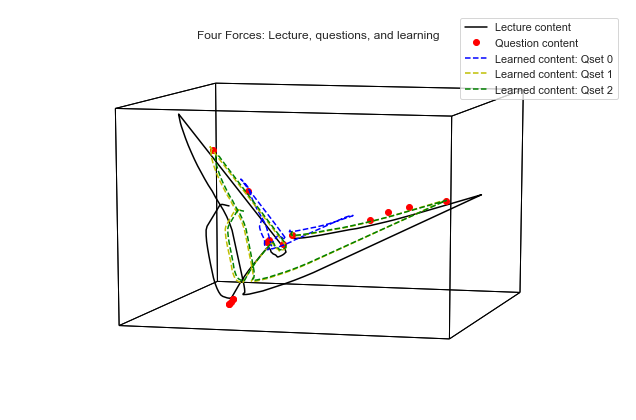

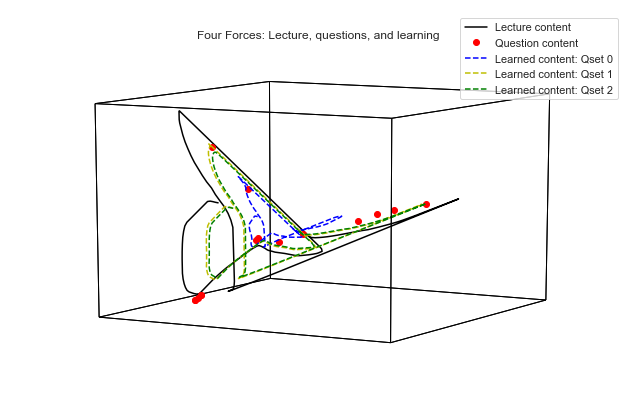

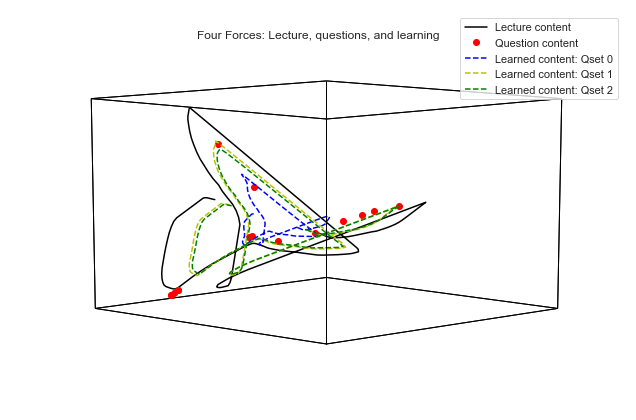

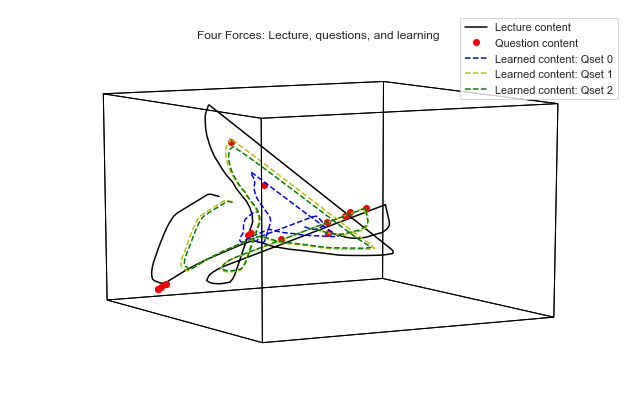

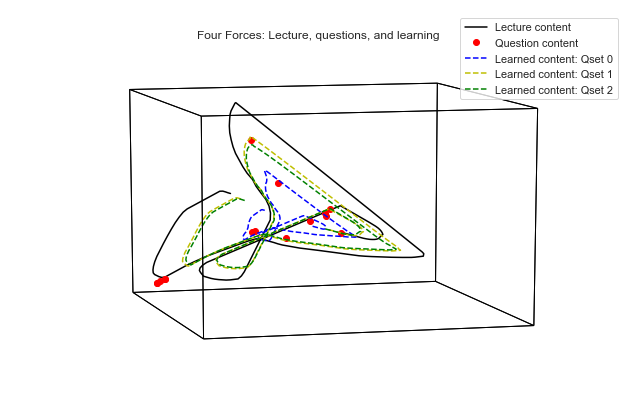

In [62]:
for azim in range(0, 360, 15):
    hyp.plot([forces_v_traj, forces_q_traj, avg_force_trace0, avg_force_trace1, avg_force_trace2], 
             fmt=['k-', 'ro', 'b--', 'y--', 'g--'], reduce='IncrementalPCA', size=[9, 6], azim=azim,
             title='Four Forces: Lecture, questions, and learning',
             legend=['Lecture content', 'Question content', 
                     'Learned content: Qset 0', 
                     'Learned content: Qset 1', 
                     'Learned content: Qset 2'])#,
#              save_path=figdir+f'fit_all/forces-traces-plots/forces-reconstructed-{azim}.pdf')
    
    plt.show()

### How does the difference between viewed and learned content change after viewing the lecture?

In [63]:
# pairwise euclidean distance (slightly less exact than np.diag of scipy.spatial.distance.cdist)
def distance(x, y):
    return np.sqrt(np.dot(x, x) - 2 * np.dot(x, y) + np.dot(y, y))

In [64]:
distances = np.array([np.diag(cdist(forces_v_traj, aft, metric='euclidean')) 
                      for aft in [avg_force_trace0, avg_force_trace1, avg_force_trace2]]).T

perfect = np.array([0 for i in range(forces_v_traj.shape[0])], ndmin=2).T

In [65]:
sns.set_palette('hls')
sns.set_context('talk')
sns.set_style('white')

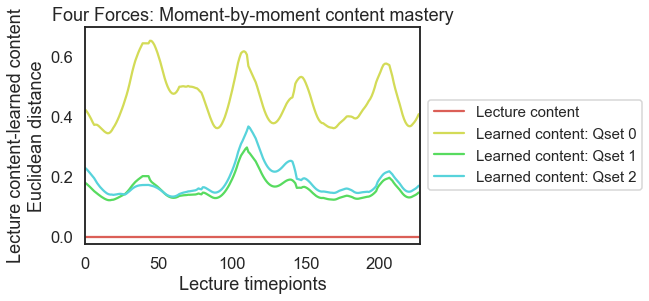

In [66]:
plt.plot(np.hstack([perfect, distances]))
plt.ylim(-.025, .7)
plt.xlim(0, forces_v_traj.shape[0])
plt.xlabel('Lecture timepionts')
plt.ylabel('Lecture content-learned content\nEuclidean distance')
plt.title('Four Forces: Moment-by-moment content mastery')
plt.legend(labels=['Lecture content','Learned content: Qset 0','Learned content: Qset 1',
                   'Learned content: Qset 2'], fontsize='small', bbox_to_anchor=(1,.7))
# plt.savefig(figdir+'fit_all/forces-lecture-trace-eucdist.pdf', bbox_inches='tight')
plt.show()

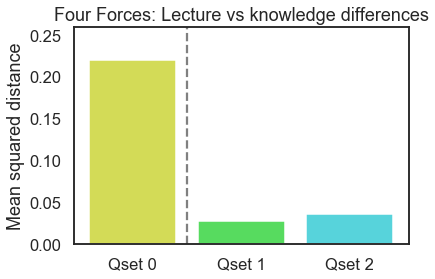

In [67]:
plt.bar(x=list(range(3)), height=(distances**2).mean(axis=0), tick_label=['Qset 0', 'Qset 1', 'Qset 2'],
       color=[(0.8288, 0.86, 0.34),(0.34, 0.86, 0.3712),(0.34, 0.8288, 0.86)])
plt.ylim(0,0.26)
plt.ylabel('Mean squared distance')
plt.title('Four Forces: Lecture vs knowledge differences')
plt.vlines(x=.5, ymin=0, ymax=0.3, linestyles='dashed', colors='gray')
# plt.savefig(figdir+'fit_all/forces-msd-by-qset.pdf', bbox_inches='tight')
plt.show()

# _Birth of Stars_

In [68]:
sns.set_context('talk')

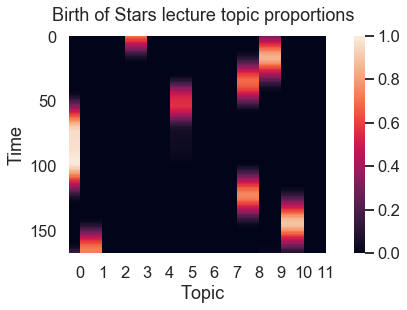

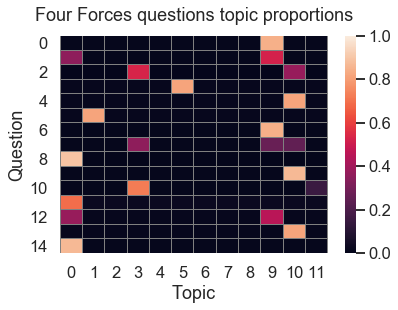

In [69]:
fig, a = plt.subplots(1,1)
fig.set_size_inches(6,4)
a = sns.heatmap(bos_v_traj, vmin=0, vmax=1, yticklabels=50)
a.set_title('Birth of Stars lecture topic proportions', y=1.04)
a.set_xlabel('Topic')
a.set_ylabel('Time')
plt.yticks(rotation=0)
a.collections[0].remove()
a.imshow(bos_v_traj, aspect='auto')
# plt.savefig(figdir+'fit_all/bos-lecture-toppropsmat.pdf', bbox_inches='tight')
plt.show()


fig, a = plt.subplots(1,1)
fig.set_size_inches(6,4)
a = sns.heatmap(bos_q_traj, vmin=0, vmax=1, linewidths=0.01, linecolor='gray')
a.set_title('Four Forces questions topic proportions', y=1.04)
a.set_xlabel('Topic')
a.set_ylabel('Question')
plt.yticks(rotation=0)
# plt.savefig(figdir+'fit_all/bos-questions-toppropsmat.pdf', bbox_inches='tight')
plt.show()

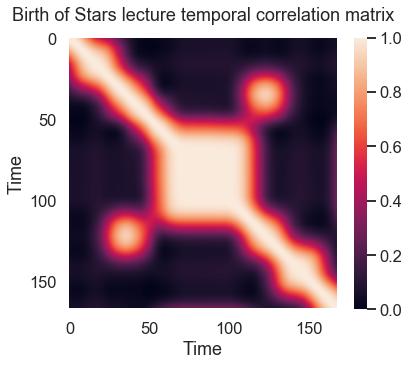

In [70]:
fig, a = plt.subplots(1,1)
fig.set_size_inches(6, 5)
a = sns.heatmap(pd.DataFrame(bos_v_traj).T.corr(), vmin=0, vmax=1, xticklabels=50, yticklabels=50)
a.set_title('Birth of Stars lecture temporal correlation matrix', y=1.04)
a.set_xlabel('Time')
a.set_ylabel('Time')
plt.yticks(rotation=0)
a.collections[0].remove()
a.imshow(pd.DataFrame(bos_v_traj).T.corr(), aspect='auto', interpolation='bilinear')
# plt.savefig(figdir+'fit_all/bos-lecture-corrmat.pdf', bbox_inches='tight')
plt.show()

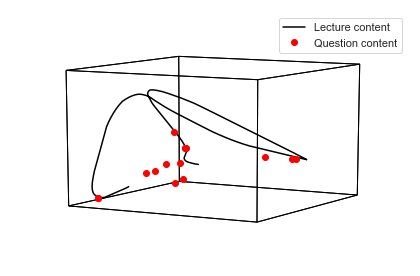

In [71]:
sns.set_context('notebook')
hyp.plot([bos_v_traj, bos_q_traj], ['k-', 'ro'], reduce='IncrementalPCA', 
         legend=['Lecture content', 'Question content'])
plt.show()

### What moments of lecture content does each question cover?

In [72]:
sns.set_palette('hls', 15)
sns.set_context('talk')

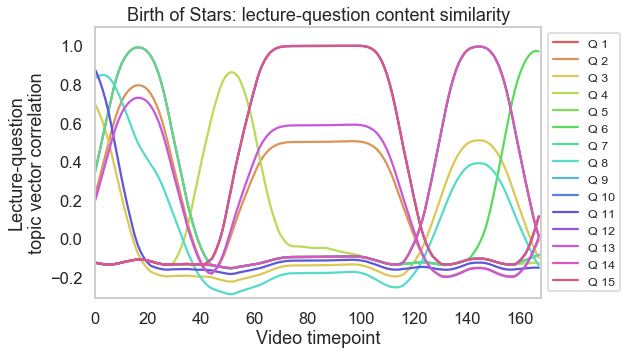

In [73]:
plt.figure(figsize=(8,5))
plt.plot(1-cdist(bos_v_traj, bos_q_traj, 'correlation'))
plt.xlim(0,bos_v_traj.shape[0])
plt.ylim(-.31,1.1)
plt.xlabel('Video timepoint')
plt.ylabel('Lecture-question\ntopic vector correlation')
plt.title('Birth of Stars: lecture-question content similarity')
plt.legend(labels=[f'Q {i+1}' for i in range(bos_q_traj.shape[0])], fontsize='x-small', bbox_to_anchor=(1,1))
plt.grid(False)
# plt.savefig(figdir+'fit_all/bos-v-q-similarity.pdf', bbox_inches='tight')
plt.show()

### reconstruct eaech subject's learning trace for each set of questions viewed

In [74]:
bos_traces_set0 = {}
bos_traces_set1 = {}
bos_traces_set2 = {}

for sid, df in sub_data.items():
    # get questions about Birth of Stars viewed in first block 
    set0_fqs = df.loc[df.set == 0].loc[df.video == 2]
    # extract their topic vectors by index
    set0_fqs_vecs = bos_q_traj[[bos_questions_samples.index(question_dict[i]) for i in set0_fqs.qID]]
    # get accuracy for those questions
    set0_fqs_acc = set0_fqs['correct?']
    
    bos_traces_set0[sid] = reconstruct_trace(bos_v_traj, set0_fqs_vecs, set0_fqs_acc)
    
for sid, df in sub_data.items():
    # get questions about Birth of Stars viewed in first block 
    set1_fqs = df.loc[df.set == 1].loc[df.video == 2]
    # extract their topic vectors by index
    set1_fqs_vecs = bos_q_traj[[bos_questions_samples.index(question_dict[i]) for i in set1_fqs.qID]]
    # get accuracy for those questions
    set1_fqs_acc = set1_fqs['correct?']
    
    bos_traces_set1[sid] = reconstruct_trace(bos_v_traj, set1_fqs_vecs, set1_fqs_acc)
    
for sid, df in sub_data.items():
    # get questions about Birth of Stars viewed in first block 
    set2_fqs = df.loc[df.set == 2].loc[df.video == 2]
    # extract their topic vectors by index
    set2_fqs_vecs = bos_q_traj[[bos_questions_samples.index(question_dict[i]) for i in set2_fqs.qID]]
    # get accuracy for those questions
    set2_fqs_acc = set2_fqs['correct?']
    
    bos_traces_set2[sid] = reconstruct_trace(bos_v_traj, set2_fqs_vecs, set2_fqs_acc)

In [75]:
avg_bos_trace0 = np.mean(list(bos_traces_set0.values()), axis=0)
avg_bos_trace1 = np.mean(list(bos_traces_set1.values()), axis=0)
avg_bos_trace2 = np.mean(list(bos_traces_set2.values()), axis=0)

In [76]:
sns.set_context('notebook')

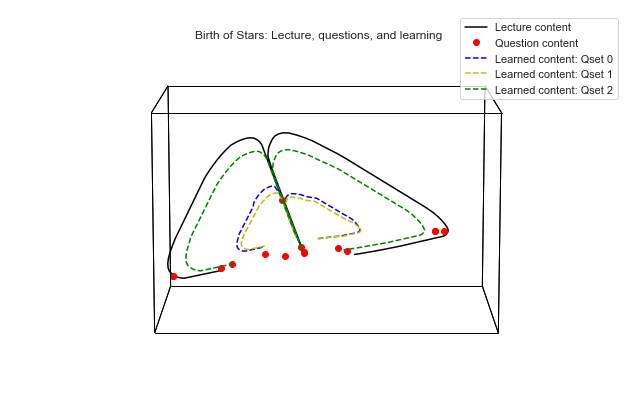

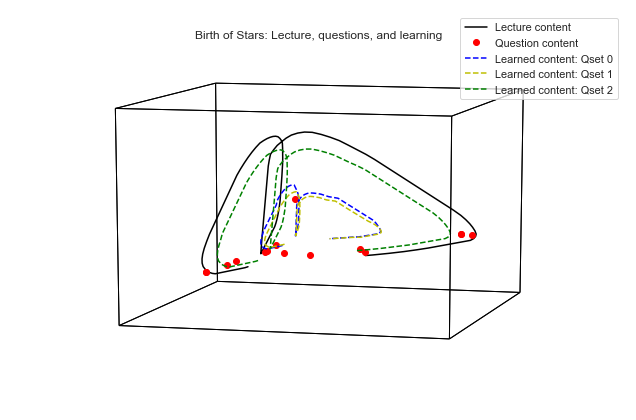

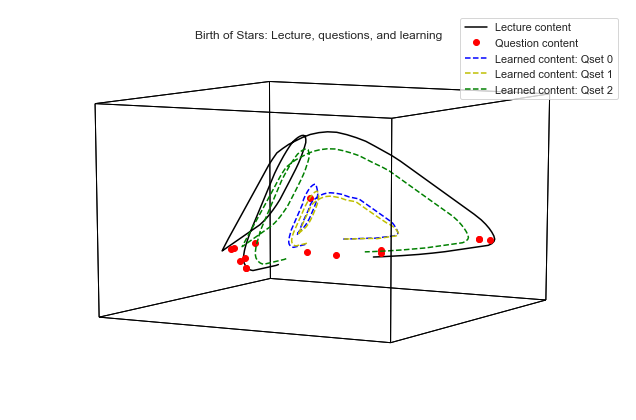

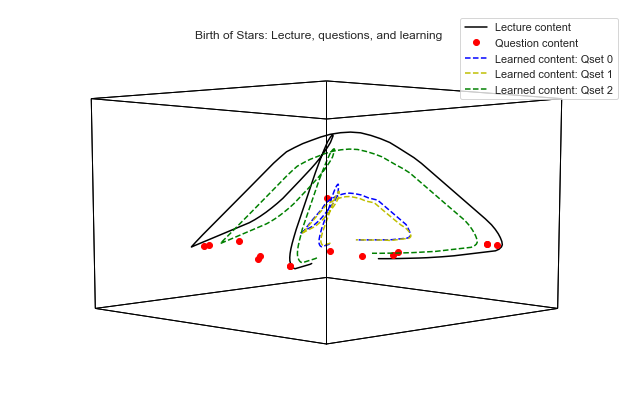

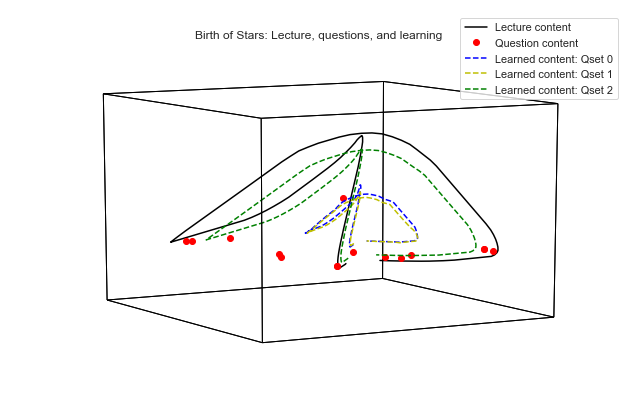

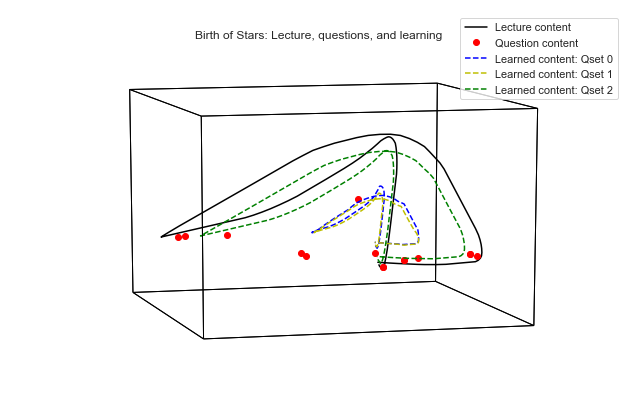

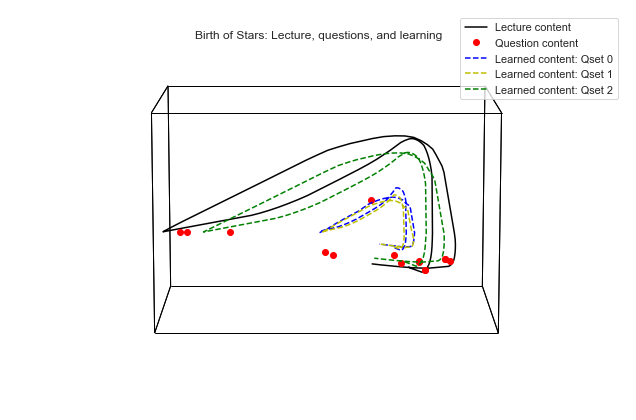

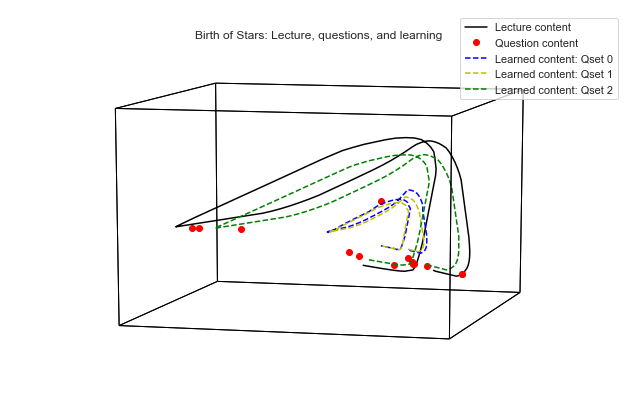

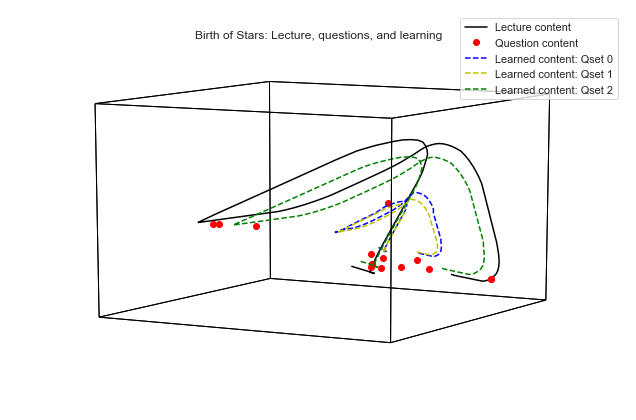

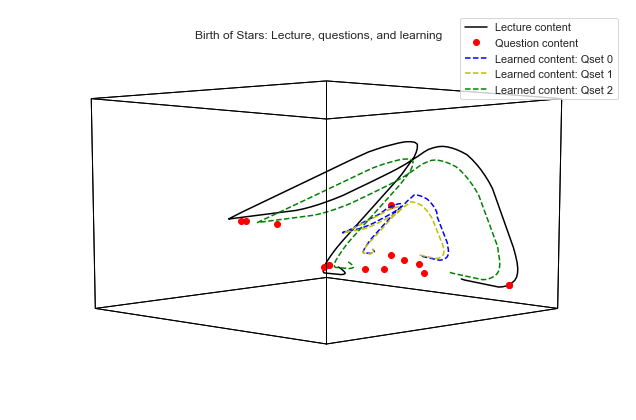

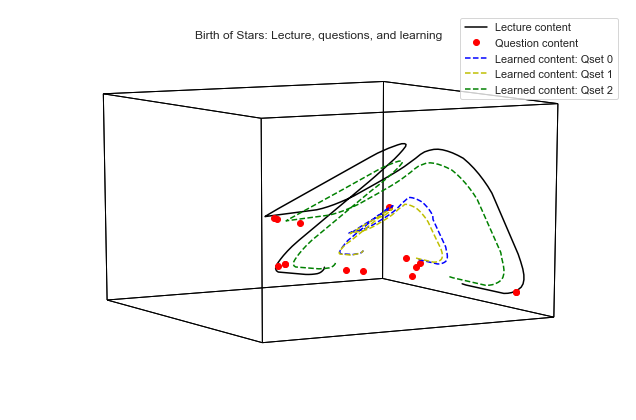

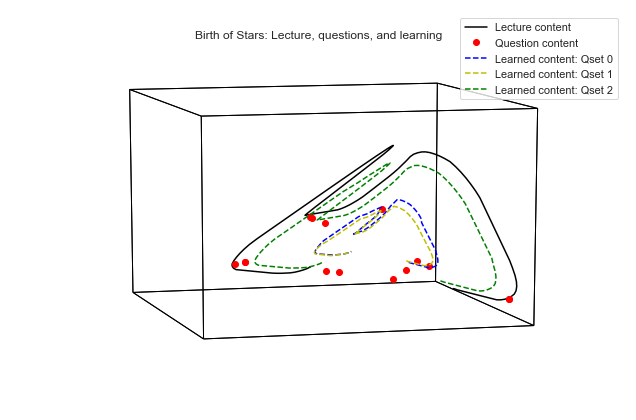

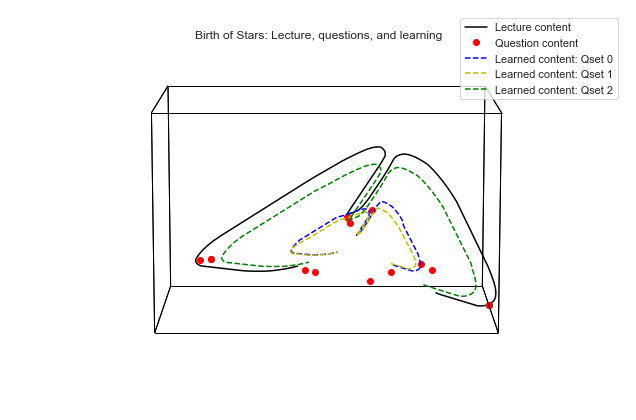

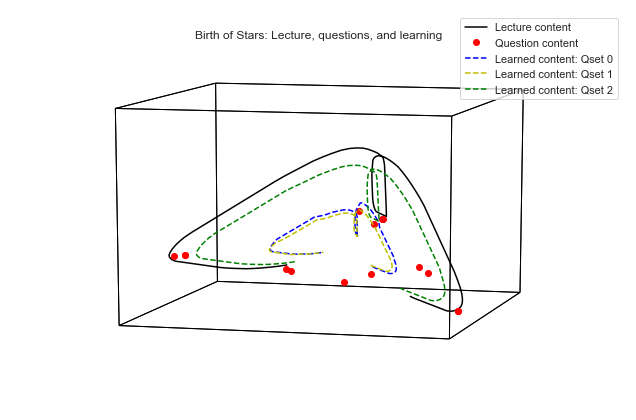

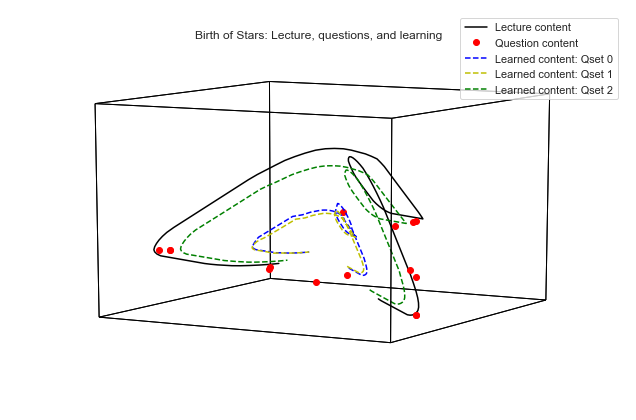

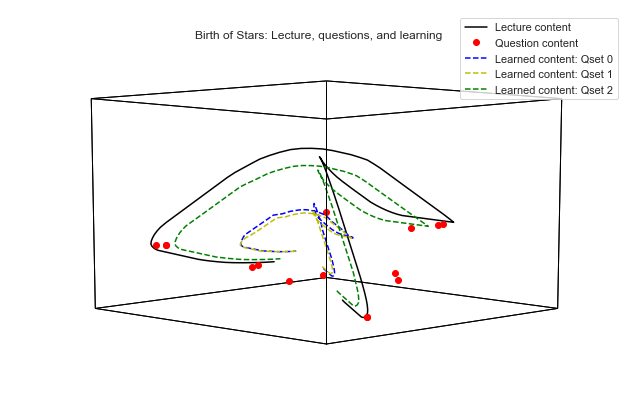

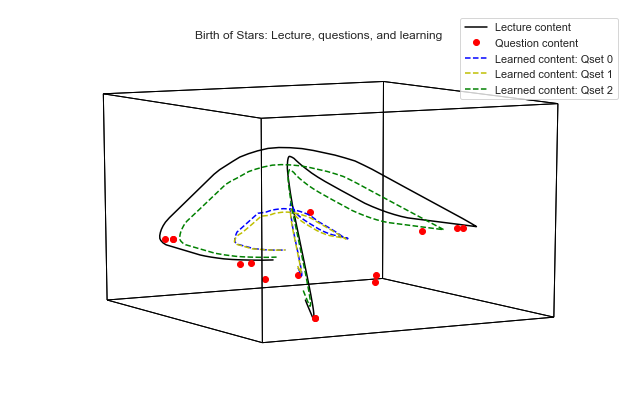

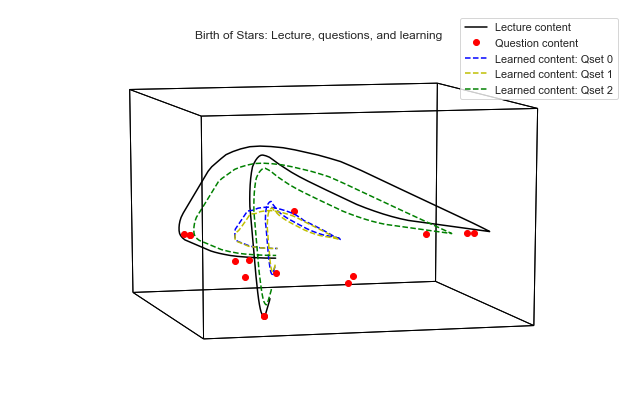

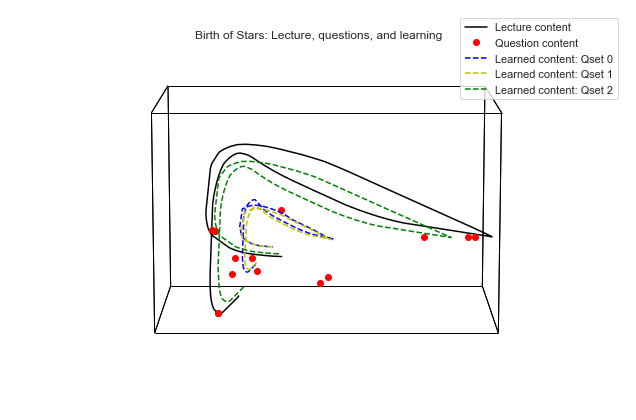

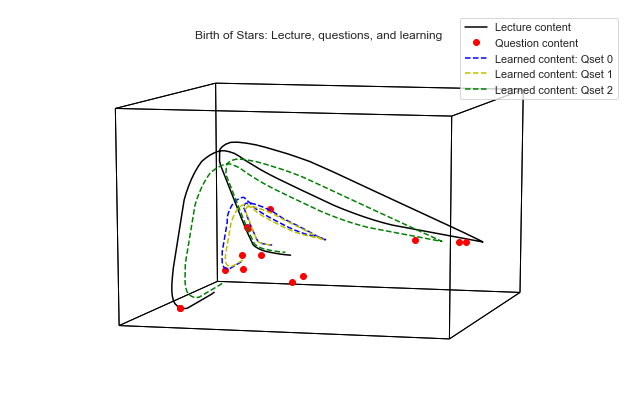

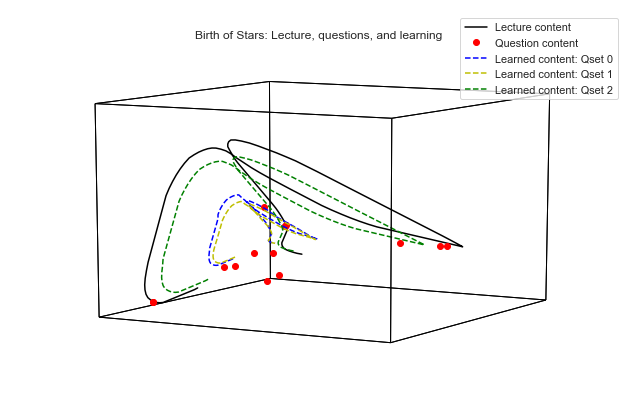

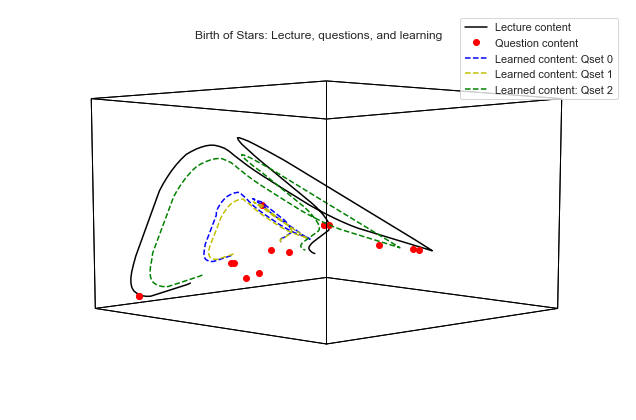

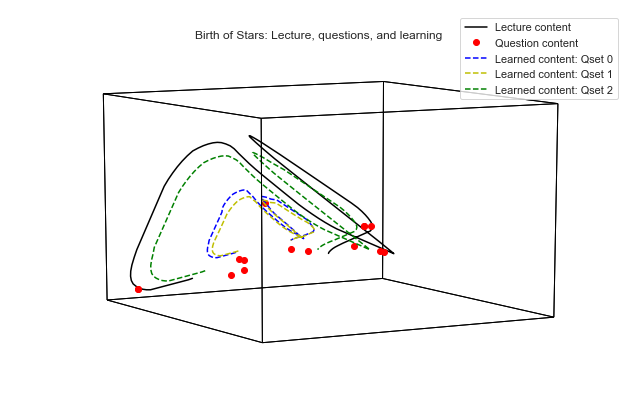

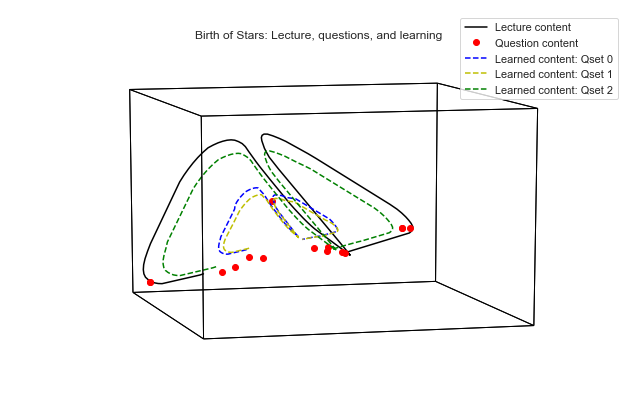

In [77]:
for azim in range(0, 360, 15):
    hyp.plot([bos_v_traj, bos_q_traj, avg_bos_trace0, avg_bos_trace1, avg_bos_trace2], 
         fmt=['k-', 'ro', 'b--', 'y--', 'g--'], reduce='IncrementalPCA', size=[9, 6], azim=azim,
         title='Birth of Stars: Lecture, questions, and learning',
         legend=['Lecture content', 'Question content', 
                 'Learned content: Qset 0', 
                 'Learned content: Qset 1', 
                 'Learned content: Qset 2'])#, 
#     save_path=figdir+f'fit_all/bos-traces-plots/bos-reconstructed-{azim}.pdf')
    
    plt.show()

### How does the difference between viewed and learned content change after viewing the lecture?

In [78]:
bos_distances = np.array([np.diag(cdist(bos_v_traj, abt, metric='euclidean')) 
                      for abt in [avg_bos_trace0, avg_bos_trace1, avg_bos_trace2]]).T

bos_perfect = np.array([0 for i in range(bos_v_traj.shape[0])], ndmin=2).T

In [79]:
sns.set_palette('hls')
sns.set_context('talk')
sns.set_style('white')

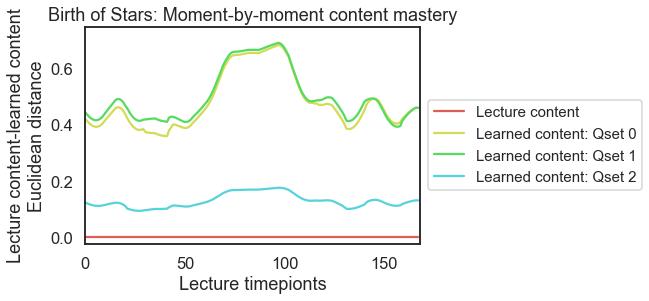

In [80]:
plt.plot(np.hstack([bos_perfect, bos_distances]))
plt.ylim(-.025, .75)
plt.xlim(0, bos_v_traj.shape[0])
plt.xlabel('Lecture timepionts')
plt.ylabel('Lecture content-learned content\nEuclidean distance')
plt.title('Birth of Stars: Moment-by-moment content mastery')
plt.legend(labels=['Lecture content','Learned content: Qset 0','Learned content: Qset 1',
                   'Learned content: Qset 2'], fontsize='small', bbox_to_anchor=(1,.7))
# plt.savefig(figdir+'fit_all/bos-lecture-trace-eucdist.pdf', bbox_inches='tight')
plt.show()

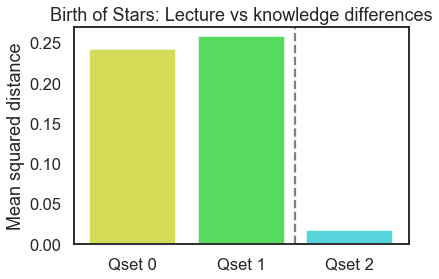

In [81]:
plt.bar(x=list(range(3)), height=(bos_distances**2).mean(axis=0), tick_label=['Qset 0', 'Qset 1', 'Qset 2'],
       color=[(0.8288, 0.86, 0.34),(0.34, 0.86, 0.3712),(0.34, 0.8288, 0.86)])
plt.ylim(0,0.27)
plt.ylabel('Mean squared distance')
plt.title('Birth of Stars: Lecture vs knowledge differences')
plt.vlines(x=1.5, ymin=0, ymax=0.3, linestyles='dashed', colors='gray')
# plt.savefig(figdir+'fit_all/bos-msd-by-qset.pdf', bbox_inches='tight')
plt.show()

### are lecture 2 questions more closely related to lecture 1 easier to get right?

In [82]:
# total number of times each question was presented in set 2 (after viewing BOS lecture)
set2_pres = data_df.loc[data_df.set == 2].loc[data_df.video == 2].qID.value_counts()
# number of times they were answered correctly
set2_correct = data_df.loc[data_df.set == 2].loc[data_df.video == 2].loc[data_df['correct?'] == 1].qID.value_counts()
# accuracy rate on those questions
set2_success = (set2_correct / set2_pres).values
# distance of those questions from nearest point on lecture 1 trajectory
lec1_dist = cdist(bos_q_traj, forces_v_traj).min(axis=1)

In [83]:
sns.set_palette('tab10')
sns.set_context('talk')
sns.set_style('ticks', {'axes.grid' : False})

In [84]:
# sns.jointplot(lec1_dist, set2_success, kind='reg', stat_func=pearsonr, space=0)
# plt.show()

### are sections of lecture 2 that are more closely related to lecture 1 easier to learn?

0.6859426941721715 1.0759039709015043e-24


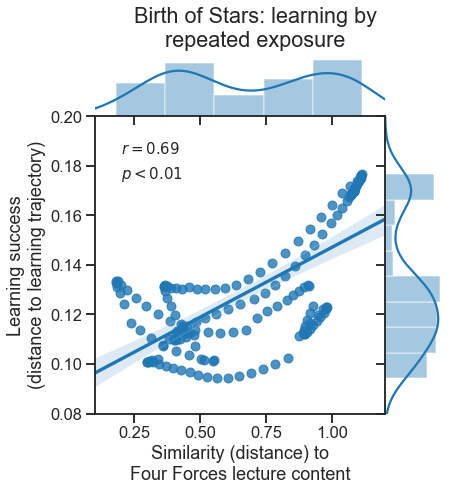

In [85]:
# x-axis: distance between lecture 2 trajectory point and nearest point on lecture 1 trajectory
# y-axis: distance between lecture 2 trajecotry point and corresponding learning trajectory point

sns.jointplot(cdist(bos_v_traj, forces_v_traj).min(axis=1), np.diag(cdist(bos_v_traj, avg_bos_trace2)), 
              kind='reg', space=0)
plt.xlabel('Similarity (distance) to\nFour Forces lecture content')
plt.ylabel('Learning success\n(distance to learning trajectory)')
plt.suptitle('Birth of Stars: learning by\nrepeated exposure', y=1.05)
plt.xlim(0.1, 1.2)
plt.ylim(0.08, 0.2)

r, p = pearsonr(cdist(bos_v_traj, forces_v_traj).min(axis=1), np.diag(cdist(bos_v_traj, avg_bos_trace2)))
print(r,p)
r = '=' + str(round(r, 2))
if p >= 0.01:
    p = '=' + str(round(p))
else:
    p = '<0.01'

plt.text(0.2,0.185, f'$r{r}$', ha='left', fontsize=15)   
plt.text(0.2,0.175, f'$p{p}$', ha='left', fontsize=15)

# plt.savefig(figdir+'fit_all/bos-success-by-ff-similarity.pdf', bbox_inches='tight')
plt.show()

-0.6957789317915527 1.2257588601418315e-25


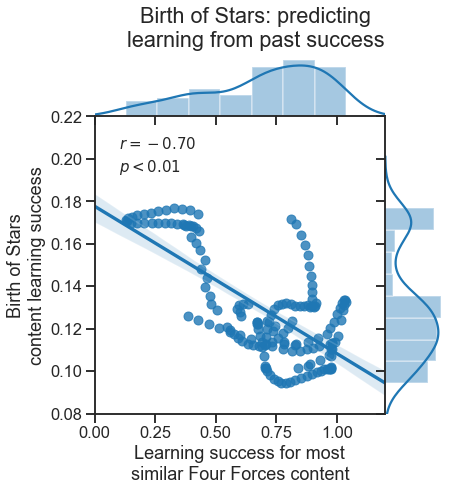

In [86]:
# x-axis: for the lecture 1 trajectory timepoint closest to each lecture 2 trajecotry timepoint, the distance 
# between it and the corresponding lecture 1 learning trajectory timepoint
# y-axis: distance between lecture 2 trajectory tiempoint and corresponding lecture 2 learning trajectory timepoint

lec2_trace2_dist = np.diag(cdist(bos_v_traj, avg_bos_trace2))
lec1rel_trace1_dist = np.diag(cdist(forces_v_traj[cdist(bos_v_traj, forces_v_traj).argmin(axis=1)], avg_force_trace1))

sns.jointplot(lec1rel_trace1_dist, lec2_trace2_dist, kind='reg', space=0)
plt.xlabel('Learning success for most\nsimilar Four Forces content')
plt.ylabel('Birth of Stars\ncontent learning success')
plt.suptitle('Birth of Stars: predicting\nlearning from past success', y=1.05)
plt.xlim(0, 1.2)
plt.ylim(0.08, 0.22)

r, p = pearsonr(lec1rel_trace1_dist, lec2_trace2_dist)
print(r,p)
r = '={:.2f}'.format(round(r, 2))
if p >= 0.01:
    p = '=' + str(round(p))
else:
    p = '<0.01'

plt.text(0.1,0.205, f'$r{r}$', ha='left', fontsize=15)   
plt.text(0.1,0.194, f'$p{p}$', ha='left', fontsize=15)

# plt.savefig(figdir+'fit_all/bos-success-by-ff-success.pdf', bbox_inches='tight')
plt.show()

### How does success answering different questions relate?

In [87]:
sns.set_style('white')

In [88]:
subs_acc = {f'qset{q}' : {f'video{v}' : None for v in range(3)} for q in range(3)}

for qset in range(3):
    for video in range(3):
        data = data_df.loc[data_df.set == qset].loc[data_df.video == video]
        acc = []
        
        for sub in data.participantID.unique():
            acc.append(len(data.loc[data.participantID == sub].loc[data['correct?'] == 1]) 
                       / len(data.loc[data.participantID == sub]))
        subs_acc[f'qset{qset}'][f'video{video}'] = acc

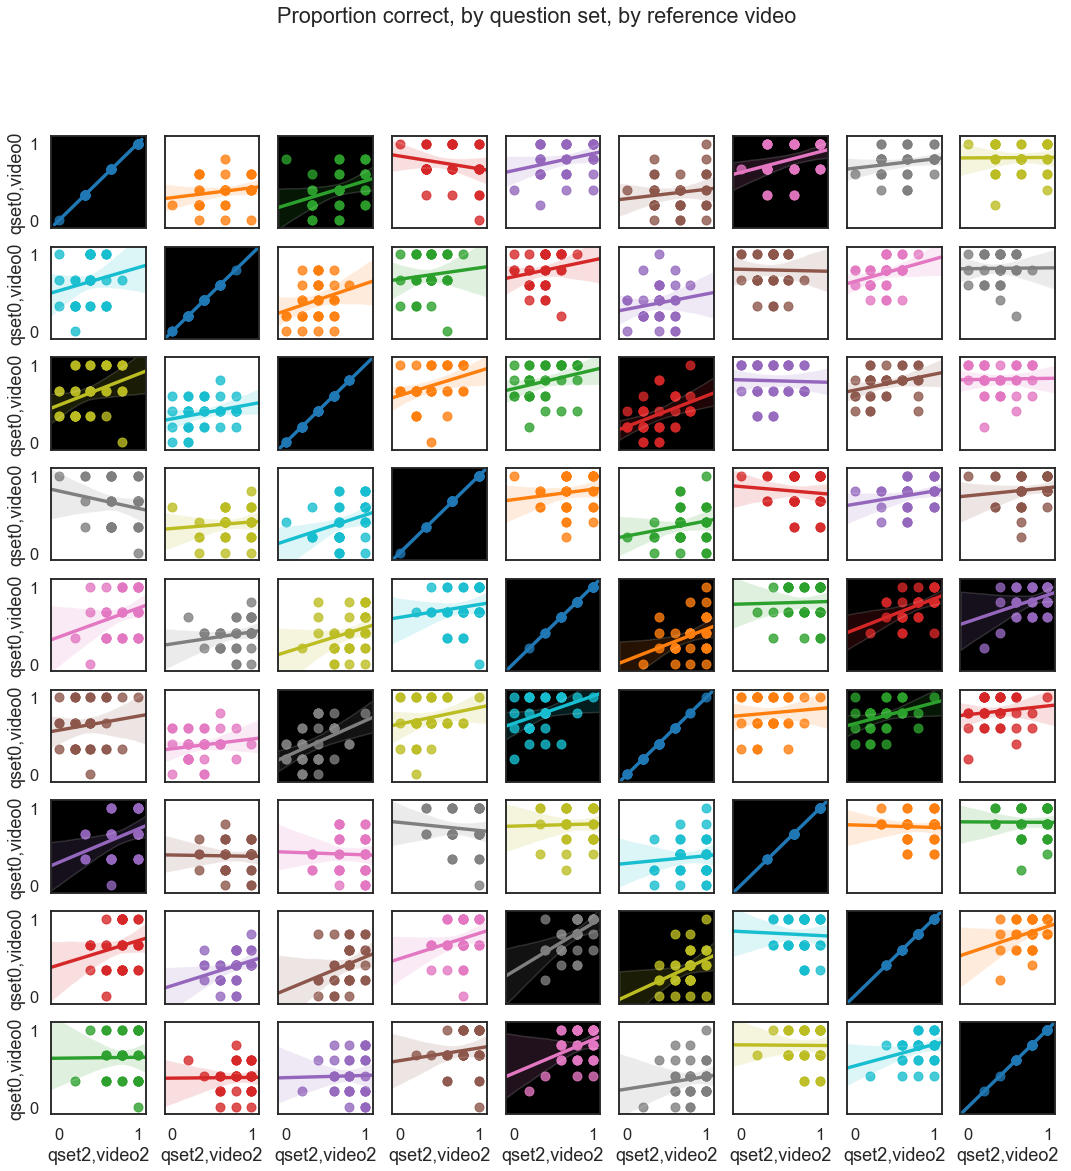

In [89]:
fig, axarr = plt.subplots(nrows=9, ncols=9, figsize=(18,18), sharex=True, sharey=True)
idx = 0

for qx, vdatax in subs_acc.items():
    for vx, accdatax in vdatax.items():
        accx = accdatax

        for qy, vdatay in subs_acc.items():
            for vy, accdatay in vdatay.items():
                accy = accdatay

                sns.regplot(accx, accy, ax=axarr.flatten()[idx])
                axarr.flatten()[idx].set_xlim(-.1,1.1)
                axarr.flatten()[idx].set_ylim(-.1,1.1)
                if not idx % 9:
                    
                    axarr.flatten()[idx].set_ylabel(f'{qy},{vy}')
                if idx >= 72:
                    axarr.flatten()[idx].set_xlabel(f'{qx},{vx}')
                    
                r, p = pearsonr(accx, accy)
                if p < 0.05:
                    axarr.flatten()[idx].set_facecolor('k')
                    
                idx += 1
                


fig.suptitle('Proportion correct, by question set, by reference video')
plt.show()

In [90]:
stats = np.empty((3,3), dtype=object)
for x, (qset_x, data_x) in zip(range(3), subs_acc['qset0'].items()):
    for y, (qset_y, data_y) in zip(range(3), subs_acc['qset0'].items()):
        r, p = pearsonr(data_x, data_y)
        print(qset_x, qset_y)
        r = '= {:.2f}'.format(round(r, 2))
        if p < 0.01:
            p = '< 0.01'
        else:
            p = '= {:.2f}'.format(round(p, 2))
        stats[x,y] = f'r {r}\np {p}'

video0 video0
video0 video1
video0 video2
video1 video0
video1 video1
video1 video2
video2 video0
video2 video1
video2 video2


In [91]:
sns.set_style('white')
cmap = sns.cm.rocket_r

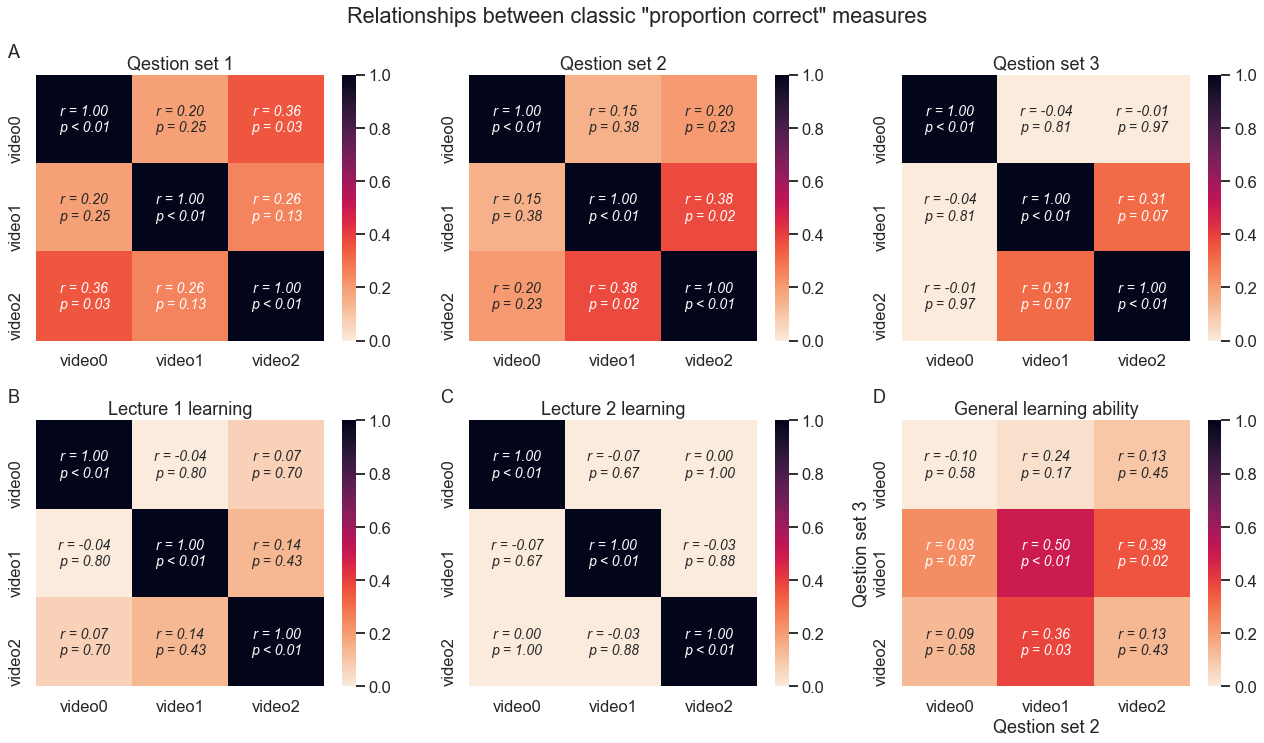

In [97]:
fig, axarr = plt.subplots(nrows=2, ncols=3, figsize=(18, 10), sharex=False, sharey=False)
axarr = axarr.flatten()

# (a)
for idx, ax in enumerate(axarr[:3]):
    
    stats = np.empty((3,3), dtype=object)
    for x, (qset_x, data_x) in zip(range(3), subs_acc[f'qset{idx}'].items()):
        for y, (qset_y, data_y) in zip(range(3), subs_acc[f'qset{idx}'].items()):
            r, p = pearsonr(data_x, data_y)
            r = '= {:.2f}'.format(round(r, 2))
            if p < 0.01:
                p = '< 0.01'
            else:
                p = '= {:.2f}'.format(round(p, 2))
            stats[x,y] = f'r {r}\np {p}'
            
    sns.heatmap(pd.DataFrame(subs_acc[f'qset{idx}']).corr(), cmap=cmap, vmin=0, vmax=1, annot=stats, fmt='', ax=ax)

    ax.set_title(f'Qestion set {idx+1}')
    for annot in ax.texts:
        annot.set_size(14)
        annot.set_style('italic')
    
    if idx == 0:
        ax.text(x=-.3, y=-.2, s='A')

        
# (b)
data = pd.DataFrame(subs_acc['qset1']) - pd.DataFrame(subs_acc['qset0'])

stats = np.empty((3,3), dtype=object)
for x, col_x in zip(range(3), data.columns):
    for y, col_y in zip(range(3), data.columns):
        r, p = pearsonr(data[col_x], data[col_y])
        r = '= {:.2f}'.format(round(r, 2))
        if p < 0.01:
            p = '< 0.01'
        else:
            p = '= {:.2f}'.format(round(p, 2))
        stats[x,y] = f'r {r}\np {p}'
        
sns.heatmap(data.corr(), cmap=cmap, vmin=0, vmax=1, annot=stats, fmt='', ax=axarr[3])

axarr[3].set_title(f'Lecture 1 learning')
for annot in axarr[3].texts:
    annot.set_size(14)
    annot.set_style('italic')
axarr[3].text(x=-.3, y=-.2, s='B')

    
# (c)
data = pd.DataFrame(subs_acc['qset2']) - pd.DataFrame(subs_acc['qset1'])

stats = np.empty((3,3), dtype=object)
for x, col_x in zip(range(3), data.columns):
    for y, col_y in zip(range(3), data.columns):
        r, p = pearsonr(data[col_x], data[col_y])
        r = '= {:.2f}'.format(round(r, 2))
        if p < 0.01:
            p = '< 0.01'
        else:
            p = '= {:.2f}'.format(round(p, 2))
        stats[x,y] = f'r {r}\np {p}'
        
sns.heatmap(data.corr(), cmap=cmap, vmin=0, vmax=1, annot=stats, fmt='', ax=axarr[4])

axarr[4].set_title(f'Lecture 2 learning')
for annot in axarr[4].texts:
    annot.set_size(14)
    annot.set_style('italic')
axarr[4].text(x=-.3, y=-.2, s='C')
    
    
# (d)
d1 = pd.DataFrame(subs_acc['qset1'])
d2 = pd.DataFrame(subs_acc['qset2'])

stats = np.empty((3,3), dtype=object)
for x, col_x in zip(range(3), d1.columns):
    for y, col_y in zip(range(3), d2.columns):
        r, p = pearsonr(d1[col_x], d2[col_y])
        r = '= {:.2f}'.format(round(r, 2))
        if p < 0.01:
            p = '< 0.01'
        else:
            p = '= {:.2f}'.format(round(p, 2))
        stats[x,y] = f'r {r}\np {p}'

sns.heatmap(d1.apply(lambda x: d2.corrwith(x)), cmap=cmap, vmin=0, vmax=1, annot=stats, fmt='', ax=axarr[5])

axarr[5].set_title(f'General learning ability')
for annot in axarr[5].texts:
    annot.set_size(14)
    annot.set_style('italic')

axarr[5].set_xlabel('Qestion set 2')
axarr[5].set_ylabel('Qestion set 3')
axarr[5].text(x=-.3, y=-.2, s='D')

fig.suptitle('Relationships between classic "proportion correct" measures', y=1.04)
plt.tight_layout()
plt.subplots_adjust(hspace=0.3)
# plt.savefig(figdir+'fit_all/prop-correct-heatmaps.pdf', bbox_inches='tight')

plt.show()

-0.09551220091000702
0.23597904259353794
0.13078765399787903
0.02885402196051591
0.4988174993299608
0.388360851278727
0.09495999204604695
0.3591999201217583
0.13443276347390368


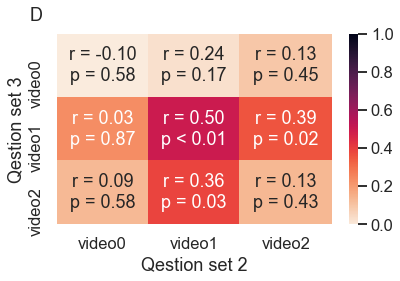

In [84]:
# (d)
d1 = pd.DataFrame(subs_acc['qset1'])
d2 = pd.DataFrame(subs_acc['qset2'])
sns.heatmap(d1.apply(lambda x: d2.corrwith(x)), cmap=cmap, vmin=0, vmax=1, annot=stats, fmt='')

stats = np.empty((3,3), dtype=object)
for x, col_x in zip(range(3), d1.columns):
    for y, col_y in zip(range(3), d2.columns):
        r, p = pearsonr(d1[col_x], d2[col_y])
        print(r)
        r = '= {:.2f}'.format(round(r, 2))
        if p < 0.01:
            p = '< 0.01'
        else:
            p = '= {:.2f}'.format(round(p, 2))
        stats[x,y] = f'r {r}\np {p}'
        



plt.xlabel('Qestion set 2')
plt.ylabel('Qestion set 3')
plt.text(x=-.3, y=-.2, s='D')

# fig.suptitle('Relationships between classic "proportion correct" measures', y=1.04)
plt.tight_layout()
# plt.subplots_adjust(hspace=0.3)
# plt.savefig(figdir+'fit_all/prop-correct-heatmaps.pdf', bbox_inches='tight')

plt.show()

In [78]:
d1.apply(lambda x: d2.corrwith(x))

video0    video1    video2
video0 -0.095512  0.028854  0.094960
video1  0.235979  0.498817  0.359200
video2  0.130788  0.388361  0.134433

### what topic dimensions are most important to success?

In [395]:
vocab = tf_vectorizer.get_feature_names()

In [396]:
# what content comprises each topic?
n_top_words = 10
topic_words = {}

for topic, component in enumerate(lda.components_):
    word_ix = np.argsort(component)[::-1][:n_top_words]
    topic_words[topic] = [vocab[i] for i in word_ix]
    
for topic, words in topic_words.items():
    print(f'topic {topic}:\n{", ".join(words)}')

topic 0:
fusion, ignition, pressure, actually, mass, hydrogen, protons, energy, gets, little
topic 1:
threshold, jupiter, like, theres, temperature, quite, fuse, actually, level, fusion
topic 2:
charge, positive, mass, coulomb, force, negative, big, lump, neutral, concentrations
topic 3:
denser, slowly, going, atoms, forward, fast, hydrogen, mass, cloud, huge
topic 4:
condensing, force, denser, gotten, different, frames, temperature, hydrogen, center, mind
topic 5:
force, strong, gravity, interaction, times, distances, strength, stronger, actually, reason
topic 6:
force, huge, electromagnetic, like, scales, way, concentrations, macro, charges, theres
topic 7:
weak, interaction, proton, going, neutrons, extra, protons, neutron, cesium, actually
topic 8:
hydrogen, nucleus, helium, atom, protons, electron, atoms, electrons, draw, atomic
topic 9:
really, hydrogen, atoms, temperature, center, dense, going, condensing, gotten, theres
topic 10:
helium, atomic, star, main, mass, keeps, sequenc

In [397]:
for topic, words in topic_words.items():
    print(topic)
    for word in words:
        in_others = 0
        for other_words in topic_words.values():
            if word in other_words:
                in_others += 1
        
        if in_others < 2:
            print(word)

0
ignition
pressure
gets
little
1
threshold
jupiter
quite
fuse
level
2
charge
positive
coulomb
negative
big
lump
neutral
3
slowly
forward
fast
cloud
4
different
mind
5
strong
times
distances
strength
stronger
reason
6
electromagnetic
scales
way
macro
charges
7
proton
neutrons
extra
neutron
cesium
8
nucleus
atom
electron
electrons
draw
9
dense
10
star
main
keeps
sequence
scale
11
magnetic
called
electro


In [398]:
# what topics comprise each trajectory?
for traj, name in zip([forces_v_traj, forces_q_traj, bos_v_traj, bos_q_traj, general_q_traj], 
                      ['Four Forces lecture', 'Four Forces questions', 'Birth of Stars lecture', 
                       'Birth of Stars questions', 'General knowledge questions']):

    print(f'{name} topics:\n{np.squeeze(np.argwhere(np.var(traj, axis=0) > 0.001))}')

Four Forces lecture topics:
[ 2  5  6  7  8 10 11]
Four Forces questions topics:
[ 2  5  6  7  8 10 11]
Birth of Stars lecture topics:
[ 0  1  3  5  8  9 10]
Birth of Stars questions topics:
[ 0  1  3  5  9 10 11]
General knowledge questions topics:
[0 3 7 8 9]


### What concepts are most important to master in lecture 1 to successfully learn the lesson content?

In [399]:
# dict to hold correlations between displacement-learning success correlations
corrs = {}

# for each topic dimension lecture varies along
for dim in np.squeeze(np.argwhere(np.var(forces_v_traj, axis=0) > 0.001)):
    sub_corrs = []
    
    # for each participant
    for sub, trace in forces_traces_set1.items():
        
        # correlate distance between learning and lecture trajs along that dimension with total distance, tpt-wise
        single_dim_dist = np.abs(trace[:,dim] - forces_v_traj[:,dim])
        full_dist = np.diag(cdist(trace, forces_v_traj))
        if np.count_nonzero(single_dim_dist) == 0 and np.count_nonzero(full_dist) == 0:
            dim_dist_corr = 1
        else:
            dim_dist_corr = pearsonr(single_dim_dist, full_dist)[0]
            
        sub_corrs.append(dim_dist_corr)
        
    corrs[dim] = np.array(sub_corrs)
    

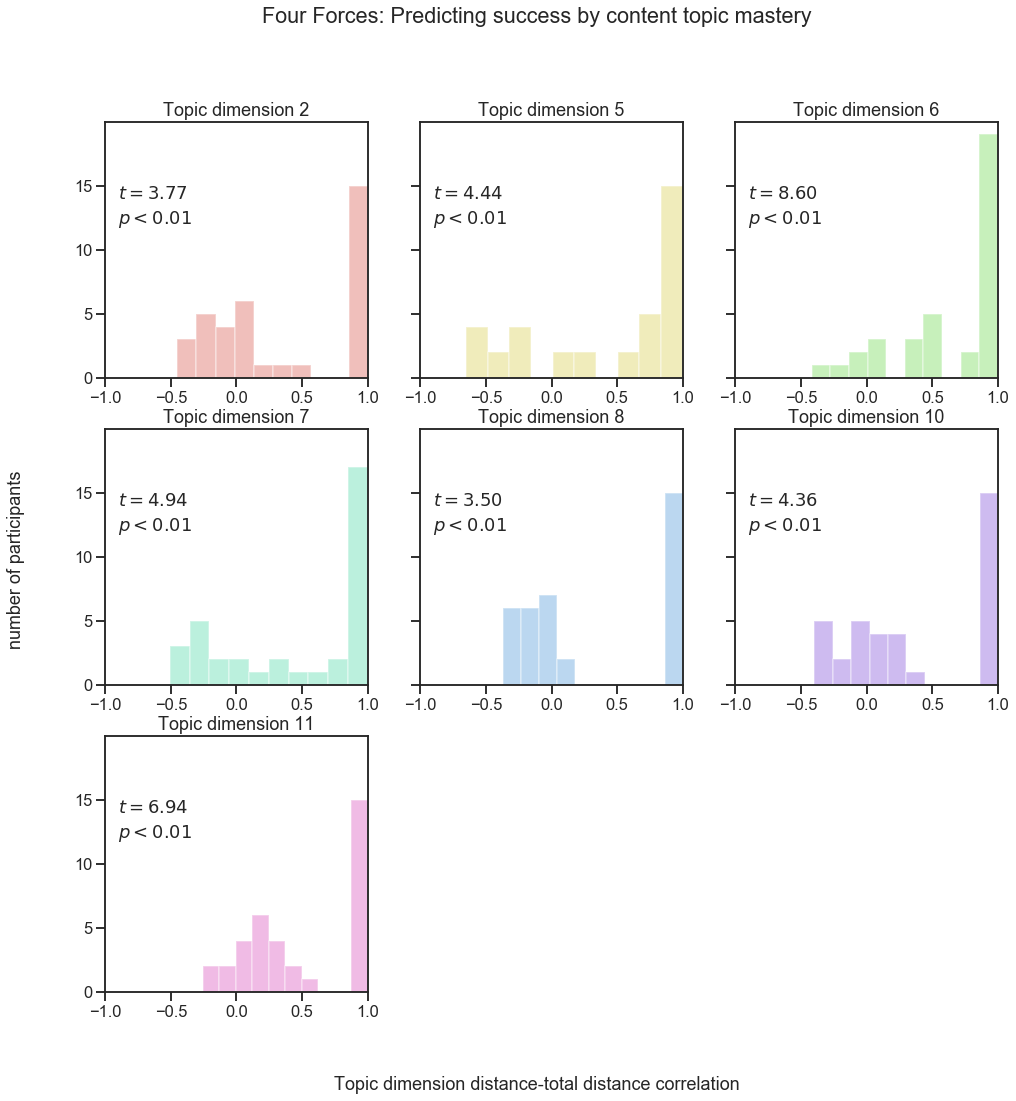

In [428]:
fig, axarr = plt.subplots(nrows=3, ncols=3, figsize=(16, 16), sharex=False, sharey=True)
axarr = axarr.flatten()

for dim, (idx, ax) in zip(corrs.keys(), enumerate(axarr)):
    
    sns.distplot(corrs[dim], bins=10, kde=False, color=sns.color_palette('hls', 7)[idx], ax=ax)
    ax.set_xlim(-1,1)
    ax.set_title(f'Topic dimension {dim}')

    transf_data = np.array([i if not np.isinf(i) else 1 for i in _r2z(corrs[dim])])
    t_stat = ttest_1samp(transf_data, 0)

    t = '={:.2f}'.format(round(t_stat[0], 2))
    if t_stat[1] >= 0.01:
        p = '=' + str(round(t_stat[1]))
    else:
        p = '<0.01'

    ax.text(s=f'$t{t}$', x=-.9, y=14)
    ax.text(s=f'$p{p}$', x=-.9, y=12)
    
for ax in axarr[idx+1:]:
    ax.axis('off')

plt.subplots_adjust()
fig.text(s='Topic dimension distance-total distance correlation', x=0.5, y=0.04, ha='center')
fig.text(s='number of participants', x=0.04, y=0.5, va='center', rotation='vertical')
plt.suptitle('Four Forces: Predicting success by content topic mastery')
# plt.savefig(figdir+'fit_all/forces-dist-dimdist-corr-distributions.pdf', bbox_inches='tight')
plt.show()

### What concepts are most important to master in lecture 2 to successfully learn the lesson content?

In [1019]:
# dict to hold correlations between displacement-learning success correlations
corrs = {}

# for each topic dimension lecture varies along
for dim in np.squeeze(np.argwhere(np.var(bos_v_traj, axis=0) > 0.001)):
    sub_corrs = []
    
    # for each participant
    for sub, trace in bos_traces_set2.items():
        
        # correlate distance between learning and lecture trajs along that dimension with total distance, tpt-wise
        single_dim_dist = np.abs(trace[:,dim] - bos_v_traj[:,dim])
        full_dist = np.diag(cdist(trace, bos_v_traj))
        if np.count_nonzero(single_dim_dist) == 0 and np.count_nonzero(full_dist) == 0:
            dim_dist_corr = 1
        else:
            dim_dist_corr = pearsonr(single_dim_dist, full_dist)[0]
            
        sub_corrs.append(dim_dist_corr)
        
    corrs[dim] = np.array(sub_corrs)
    
# barplot: each bar is a topic dimension, y-axis is correlation between displacement along that topic dim and
# learning success


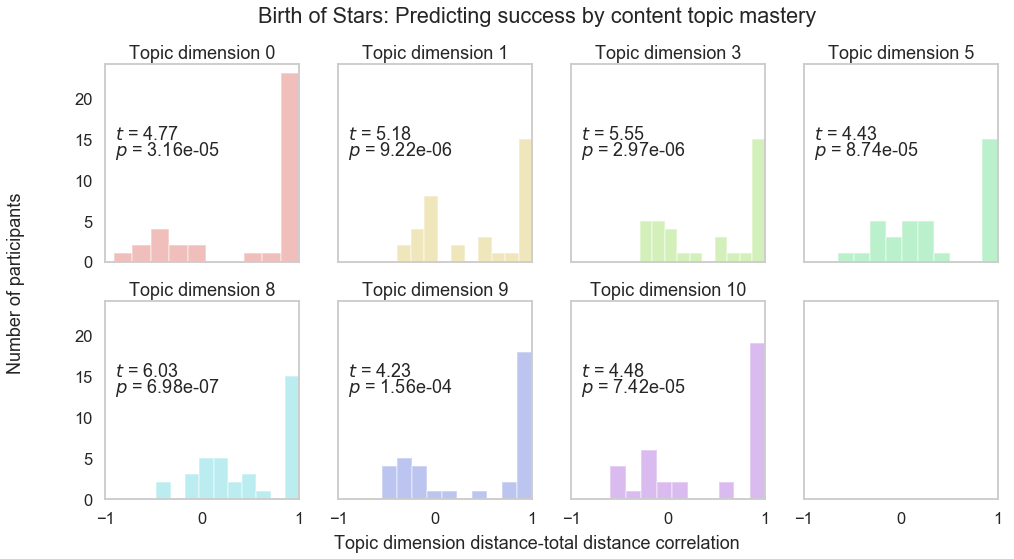

In [1020]:
fig, axarr = plt.subplots(nrows=2, ncols=4, figsize=(16, 8), sharex=True, sharey=True)

for dim, (idx, ax) in zip(corrs.keys(), enumerate(axarr.flatten())):
    
    sns.distplot(corrs[dim], bins=10, kde=False, color=sns.color_palette('hls', 8)[idx], ax=ax)
    ax.set_xlim(-1,1)
    ax.set_title(f'Topic dimension {dim}')
    
    transf_data = np.array([i if not np.isinf(i) else 1 for i in _r2z(corrs[dim])])
    t_stat = ttest_1samp(transf_data, 0)
    t, p = t_stat[0], t_stat[1]
    if p < 0.01:
        p = '%.2e' % Decimal(str(t_stat[1]))
    else:
        p = str(p)[:4]
    
    ax.text(s=f'$t$ = {str(t)[:4]}', x=-.9, y=15)
    ax.text(s=f'$p$ = {p}', x=-.9, y=13)
    
# axarr[1,2].axis('off')
plt.subplots_adjust()
fig.text(s='Topic dimension distance-total distance correlation', x=0.5, y=0.04, ha='center')
fig.text(s='Number of participants', x=0.04, y=0.5, va='center', rotation='vertical')
plt.suptitle('Birth of Stars: Predicting success by content topic mastery')
# plt.savefig(figdir+'fit_all/bos-dist-dimdist-corr-distributions.pdf', bbox_inches='tight')
plt.show()

### What concepts are most important to take away from lecture 1 to be successful in learning lecture 2?

In [1021]:
# # dict to hold correlations between displacement-learning success correlations
# single_dims = {}
# msds = {}

# # for each topic dimension lecture varies along
# for dim in range(20):
#     sub_single_dims = []
#     sub_msds = []
    
#     # for each participant
#     for sub, trace in forces_traces_set1.items():
        
#         # get distance between learning and lecture 1 trajs along that dimension and total distance
#         # between lecture 2 and lecture 2 learning trajectory
#         single_dim_msd = ((trace[:,dim] - forces_v_traj[:,dim])**2).mean()
#         lec2_full_msd = (np.diag(cdist(bos_traces_set2[sub], bos_v_traj))**2).mean()
        
#         sub_single_dims.append(single_dim_msd)
#         sub_msds.append(lec2_full_msd)
    
#     single_dims[dim] = np.array(sub_single_dims)
#     msds[dim] = np.array(sub_msds)
    
# # barplot: each bar is a topic dimension, y-axis is correlation between displacement along that topic dim and
# # learning success


In [1022]:
# fig, axarr = plt.subplots(nrows=5, ncols=4, figsize=(20, 16))#, sharex=True, sharey=True)

# for dim, (idx, ax) in zip(single_dims.keys(), enumerate(axarr.flatten())):
#     sns.regplot(single_dims[dim], msds[dim], color=sns.color_palette('hls', 20)[idx], ax=ax)
#     ax.set_xlim(-1,1)
#     ax.set_title(f'Topic dimension {dim}')
    
# #     transf_data = np.array([i if not np.isinf(i) else 1 for i in _r2z(corrs[dim])])
# #     t_stat = ttest_1samp(transf_data, 0)
# #     t, p = t_stat[0], t_stat[1]
# #     if p < 0.01:
# #         p = '%.2e' % Decimal(str(t_stat[1]))
# #     else:
# #         p = str(p)[:4]
    
# #     ax.text(s=f'$t$ = {str(t)[:4]}', x=-.9, y=26)
# #     ax.text(s=f'$p$ = {p}', x=-.9, y=23)
    

# plt.subplots_adjust()
# # fig.text(s='Topic dimension distance-total distance correlation', x=0.5, y=0.04, ha='center')
# # fig.text(s='number of participants', x=0.04, y=0.5, va='center', rotation='vertical')
# # plt.suptitle('Birth of Stars: Predicting success by content topic mastery')
# # # plt.savefig(figdir+'fit_all/bos-dist-dimdist-corr-distributions.pdf', bbox_inches='tight')
# plt.show()

In [430]:
traj_dir = '../data analysis/trajectories/'

In [440]:
# np.save(traj_dir+'forces_v_traj.npy', forces_v_traj)
# np.save(traj_dir+'bos_v_traj.npy', bos_v_traj)
# np.save(traj_dir+'forces_q_traj.npy', forces_q_traj)
# np.save(traj_dir+'bos_q_traj.npy', bos_q_traj)
# np.save(traj_dir+'general_q_traj.npy', general_q_traj)

In [441]:
# np.save(traj_dir+'avg_force_trace0.npy', avg_force_trace0)
# np.save(traj_dir+'avg_force_trace1.npy', avg_force_trace1)
# np.save(traj_dir+'avg_force_trace2.npy', avg_force_trace2)
# np.save(traj_dir+'avg_bos_trace0.npy', avg_bos_trace0)
# np.save(traj_dir+'avg_bos_trace1.npy', avg_bos_trace1)
# np.save(traj_dir+'avg_bos_trace2.npy', avg_bos_trace2)

In [442]:
# with open(traj_dir+'forces_traces_set0.p', 'wb') as f:
#     pickle.dump(forces_traces_set0, f)
    
# with open(traj_dir+'forces_traces_set1.p', 'wb') as f:
#     pickle.dump(forces_traces_set1, f)
    
# with open(traj_dir+'forces_traces_set2.p', 'wb') as f:
#     pickle.dump(forces_traces_set2, f)
    
# with open(traj_dir+'bos_traces_set0.p', 'wb') as f:
#     pickle.dump(forces_traces_set0, f)
    
# with open(traj_dir+'bos_traces_set1.p', 'wb') as f:
#     pickle.dump(bos_traces_set1, f)
    
# with open(traj_dir+'bos_traces_set2.p', 'wb') as f:
#     pickle.dump(bos_traces_set2, f)

In [444]:
[len(i.split()) for i in forces_video_samples]

[110,
 107,
 107,
 111,
 109,
 110,
 112,
 111,
 111,
 112,
 111,
 108,
 108,
 108,
 107,
 107,
 108,
 107,
 105,
 106,
 104,
 103,
 106,
 108,
 109,
 109,
 110,
 107,
 104,
 102,
 102,
 102,
 104,
 106,
 108,
 109,
 110,
 107,
 104,
 100,
 99,
 101,
 105,
 110,
 114,
 113,
 114,
 113,
 113,
 111,
 113,
 113,
 115,
 116,
 119,
 119,
 119,
 115,
 111,
 109,
 107,
 105,
 105,
 104,
 105,
 104,
 102,
 100,
 102,
 101,
 101,
 101,
 103,
 105,
 104,
 104,
 104,
 103,
 102,
 102,
 102,
 103,
 103,
 102,
 103,
 105,
 104,
 102,
 102,
 102,
 104,
 102,
 103,
 107,
 107,
 107,
 108,
 110,
 110,
 109,
 108,
 109,
 109,
 106,
 107,
 108,
 109,
 110,
 105,
 104,
 102,
 99,
 97,
 95,
 97,
 96,
 94,
 96,
 96,
 94,
 92,
 94,
 94,
 95,
 95,
 98,
 97,
 97,
 99,
 96,
 96,
 98,
 97,
 98,
 99,
 100,
 97,
 98,
 99,
 99,
 97,
 101,
 102,
 101,
 102,
 105,
 105,
 107,
 108,
 105,
 104,
 105,
 102,
 104,
 106,
 107,
 105,
 105,
 106,
 106,
 102,
 104,
 104,
 105,
 108,
 109,
 111,
 113,
 110,
 107,
 106,
 104

In [448]:
np.mean([len(i.split()) for i in fvs_formatted])

46.723320158102766

In [449]:
np.mean([len(i.split()) for i in bvs_formatted])

47.58031088082902